In [ ]:
import os
import sys
import pandas as pd
import argparse
import warnings
from utils import *
from torch import nn
import copy
from tqdm import tqdm
import random 
from data_loader import *
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import numpy as np
from http import HTTPStatus
import dashscope
from xgboost import XGBRegressor
from dashscope import Generation
import json
# import openai
from deepseek import DeepSeekClient
import os
from train import *
from model import GurobiPowerScheduler_milp
import pickle
from together import Together
from openai import OpenAI
warnings.filterwarnings("ignore")
#set deepseek and openai API keys



dashscope.api_key = 'YOUR KEY'
DEEPSEEK_API_KEY = 'YOUR KEY'
OPENAI_API_KEY = 'YOUR KEY'
LLAMA_API_KEY= 'YOUR KEY'

In [24]:
parser_train = argparse.ArgumentParser()
parser_train.add_argument('--seq_len', type=int, default=24*7)
parser_train.add_argument('--pred_len', type=int, default=24)
parser_train.add_argument('--label_len', type=int, default=0)
parser_train.add_argument('--train_length', type=int, default=17376)
parser_train.add_argument('--target', type=str, default='target')
parser_train.add_argument('--scale', type=bool, default=True)
parser_train.add_argument('--inverse', type=bool, default=True)
parser_train.add_argument('--num_epochs', type=int, default=1000)
parser_train.add_argument('--mode', type=str, default='seq2seq')
parser_train.add_argument('--quantiles', type=list, default=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95])
parser_train.add_argument('--lr', type=float, default=1e-3)
parser_train.add_argument('--patience', type=int, default=5)
parser_train.add_argument('--hidden_layers', type=list, default=[128,128,128])
parser_train.add_argument('--e2e_num_epochs', type=int, default=5)
parser_train.add_argument('--e2e_ft_lr', type=float, default=1e-6)
parser_train.add_argument('--e2e_lr', type=float, default=1e-7)#1e-7
parser_train.add_argument('--ft_lr', type=float, default=1e-4)
parser_train.add_argument('--batch_size', type=int, default=16)
parser_train.add_argument('--device', type=str, default='cuda:0' if torch.cuda.is_available() else 'cpu')
parser_train.add_argument('--epsion_p', type=float, default=1e1)
parser_train.add_argument('--epsion_l', type=float, default=1e1)
parser_train.add_argument('--metric_list', type=list, default=['pinball_loss','winkler_score_0.1','MAE','RMSE'])


parser_train.add_argument('--N_g', type=int, default=3)
parser_train.add_argument('--T', type=int, default=24)
parser_train.add_argument('--N', type=int, default=25)
parser_train.add_argument('--x_max', type=int, default=[1500,1800,2000])
parser_train.add_argument('--x_min', type=int, default=[200,300,400])
parser_train.add_argument('--z_pos_max', type=list, default=[500,700,800])
parser_train.add_argument('--z_neg_max', type=list, default=[500,700,800])
parser_train.add_argument('--z_pos_min', type=int, default=0)
parser_train.add_argument('--z_neg_min', type=int, default=0)
parser_train.add_argument('--r_neg', type=int, default=[800,800,500])
parser_train.add_argument('--r_pos', type=int, default=[800,800,500])
parser_train.add_argument('--alpha', type=list, default=[0.03 for i in range(24)]+[0.028 for i in range(24)]+[0.032 for i in range(24)])
parser_train.add_argument('--alpha_pos', type=list, default=[0.02 for i in range(24)]+[0.018 for i in range(24)]+[0.022 for i in range(24)])
parser_train.add_argument('--alpha_neg', type=list, default=[0.01 for i in range(24)]+[0.009 for i in range(24)]+[0.011 for i in range(24)])

parser_train.add_argument('--rho_z_pos', type=list, default=[0.05 for i in range(24)]+[0.045 for i in range(24)]+[0.055 for i in range(24)])
parser_train.add_argument('--rho_z_neg', type=list, default=[0.01 for i in range(24)]+[0.008 for i in range(24)]+[0.012 for i in range(24)])

parser_train.add_argument('--rho_r_pos', type=list, default=[0.1 for i in range(24)])
parser_train.add_argument('--rho_r_neg', type=list, default=[0.05 for i in range(24)])
parser_train.add_argument('--min_up_time', type=int, default=6)
parser_train.add_argument('--price_ratio_large', type=float, default=2.5)
parser_train.add_argument('--price_ratio_small', type=float, default=0.8)
parser_train.add_argument('--flag_dynamic_price', type=bool, default=False)
parser_train.add_argument('--flag_dynamic_mode', type=int, default=2)
parser_train.add_argument('--upper_quantiles', type=float, default=0.95)
parser_train.add_argument('--lower_quantiles', type=float, default=0.05)
parser_train.add_argument('--epsion', type=float, default=1)
parser_train.add_argument('--LLM_type', type=str, default='Deepseek')
args = parser_train.parse_args(args=[])

In [25]:
train_load_data,train_load_loader=get_load_data(args,flag='train')
val_load_data,val_load_loader=get_load_data(args,flag='val')
test_load_data,test_load_loader=get_load_data(args,flag='test')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

X_test=train_load_data.inverse_transform_X(test_load_data.X)
X_train=train_load_data.inverse_transform_X(train_load_data.X)
X_val=train_load_data.inverse_transform_X(val_load_data.X)

../Data/GEF_data/data(3 year).csv
(26113, 219)
../Data/GEF_data/data(3 year).csv
(26113, 219)
../Data/GEF_data/data(3 year).csv
(26113, 219)


In [26]:
from utils import *
combined_train_data,combined_train_loader,combined_val_data,combined_val_loader,combined_test_data,combined_test_loader,combined_fine_tune_data,combined_fine_tune_loader = obtain_price(args,train_load_data,val_load_data,test_load_data)
data_iter = iter(combined_test_loader)
input_load_test, labels_load_test, alpha_test, alpha_z_test, rho_z_test, rho_r_test = next(data_iter)

alpha_sample=alpha_test[0,:].detach().cpu().numpy()
alpha_z_sample=alpha_z_test[0,:].detach().cpu().numpy()
rho_z_sample=rho_z_test[0,:].detach().cpu().numpy()
rho_r_sample=rho_r_test[0,:].detach().cpu().numpy()

optimization_module = GurobiPowerScheduler_milp(args, alpha_sample, alpha_z_sample, rho_z_sample, rho_r_sample)

Test data is not shuffled
Test data is not shuffled
[1500. 1800. 2000.]
[200. 300. 400.]


In [27]:
input_size=train_load_data.X.shape[-1]
output_size=24
set_seed(42)

layer_sizes=[128,128,128]
model_load=ANN(input_size=input_size, layer_sizes=layer_sizes, output_size=output_size).to(device)
train(args, model_load, train_load_loader, val_load_loader,dir_best_model='../Model/best_ann_load.pt')

Using device: cuda:0
Epoch [1/1000] Train Loss: 0.0588 Val Loss: 0.0193
Epoch [2/1000] Train Loss: 0.0090 Val Loss: 0.0075
Epoch [3/1000] Train Loss: 0.0059 Val Loss: 0.0069
Epoch [4/1000] Train Loss: 0.0054 Val Loss: 0.0066


Epoch [5/1000] Train Loss: 0.0053 Val Loss: 0.0064
Epoch [6/1000] Train Loss: 0.0049 Val Loss: 0.0060
Epoch [7/1000] Train Loss: 0.0049 Val Loss: 0.0057
Epoch [8/1000] Train Loss: 0.0052 Val Loss: 0.0055
Epoch [9/1000] Train Loss: 0.0043 Val Loss: 0.0052
Epoch [10/1000] Train Loss: 0.0041 Val Loss: 0.0048
Epoch [11/1000] Train Loss: 0.0038 Val Loss: 0.0046
Epoch [12/1000] Train Loss: 0.0037 Val Loss: 0.0043
Epoch [13/1000] Train Loss: 0.0034 Val Loss: 0.0041
Epoch [14/1000] Train Loss: 0.0036 Val Loss: 0.0038
Epoch [15/1000] Train Loss: 0.0034 Val Loss: 0.0036
Epoch [16/1000] Train Loss: 0.0028 Val Loss: 0.0038
Epoch [17/1000] Train Loss: 0.0029 Val Loss: 0.0035
Epoch [18/1000] Train Loss: 0.0029 Val Loss: 0.0032
Epoch [19/1000] Train Loss: 0.0026 Val Loss: 0.0029
Epoch [20/1000] Train Loss: 0.0025 Val Loss: 0.0030
Epoch [21/1000] Train Loss: 0.0025 Val Loss: 0.0034
Epoch [22/1000] Train Loss: 0.0025 Val Loss: 0.0027
Epoch [23/1000] Train Loss: 0.0025 Val Loss: 0.0030
Epoch [24/1000] T

In [28]:
cost_calculation=False
if 'cost_lists_milp.pkl' not in os.listdir():
    cost_calculation=True
else:
    with open('cost_lists_milp.pkl', 'rb') as f:
        cost_result=pickle.load(f)
        cost_list_train=cost_result['cost_list_train']
        cost_list_train_ideal=cost_result['cost_list_train_ideal']
        cost_list_val=cost_result['cost_list_val']
        cost_list_val_ideal=cost_result['cost_list_val_ideal']
        cost_list_test=cost_result['cost_list_test']
        cost_list_ideal=cost_result['cost_list_test_ideal']

In [29]:
test_input=torch.tensor(test_load_data.X).to(device).float()
test_pred_nor=model_load(test_input).detach().cpu().numpy()
test_pred = train_load_data.inverse_transform(test_pred_nor)
test_actual_nor=test_load_data.y
test_actual = train_load_data.inverse_transform(test_actual_nor)

print(MAE(test_pred,test_actual),RMSE(test_pred,test_actual),MAPE(test_pred,test_actual))

if cost_calculation:
    cost_list_test=[]
    cost_list_ideal=[]
    for i in range(len(test_pred)):
        forecasts=test_pred[i,:]
        actual=test_actual[i,:]
        _,_,costs_org=optimization_module.forward(forecasts,actual)
        _,_,costs_ideal=optimization_module.forward(actual,actual)
        cost_list_test.append(costs_org)
        cost_list_ideal.append(costs_ideal)


val_input=torch.tensor(val_load_data.X).to(device).float()
val_pred_nor=model_load(val_input).detach().cpu().numpy()
val_pred = train_load_data.inverse_transform(val_pred_nor)
val_actual_nor=val_load_data.y#.reshape(-1,1)
val_actual = train_load_data.inverse_transform(val_actual_nor)

print(MAE(val_pred,val_actual),RMSE(val_pred,val_actual),MAPE(val_pred,val_actual))

if cost_calculation:
    cost_list_val_ideal=[]
    cost_list_val=[]
    for i in range(len(val_pred)):
        forecasts=val_pred[i,:]
        actual=val_actual[i,:]
        _,_,costs_org=optimization_module.forward(forecasts,actual)
        _,_,costs_ideal=optimization_module.forward(actual,actual)
        cost_list_val.append(costs_org)
        cost_list_val_ideal.append(costs_ideal)

train_input=torch.tensor(train_load_data.X).to(device).float()
train_pred_nor=model_load(train_input).detach().cpu().numpy()
train_pred = train_load_data.inverse_transform(train_pred_nor)
train_actual_nor=train_load_data.y#.reshape(-1,1)
train_actual = train_load_data.inverse_transform(train_actual_nor)
print(MAE(train_pred,train_actual),RMSE(train_pred,train_actual),MAPE(train_pred,train_actual))
if cost_calculation:
    cost_list_train_ideal=[]
    cost_list_train=[]
    for i in range(len(train_pred)):
        forecasts=train_pred[i,:]
        actual=train_actual[i,:]
        _,_,costs_org=optimization_module.forward(forecasts,actual)
        _,_,costs_ideal=optimization_module.forward(actual,actual)
        cost_list_train.append(costs_org)
        cost_list_train_ideal.append(costs_ideal)
    #save cost_list_train，cost_list_train_ideal，cost_list_val，cost_list_val_ideal，cost_list_test，cost_list_test_ideal into a pkl

108.93030977797234 139.44284533957995 0.029723884245756324
93.48481050557758 131.1995755421263 0.027242015189285804
86.26146852859128 118.6684663545049 0.025493223048933752


In [30]:
from E2E import E2E_test_ideal,E2E_test,E2E_train

In [31]:
from model import *
from E2E import *

In [32]:
cost_list_test_insert=[cost_list_test[i]-cost_list_ideal[i] for i in range(len(cost_list_test))]
actual_load_test_insert=test_actual_nor
forecasts_load_test_insert=test_pred_nor

cost_list_train_insert=[cost_list_train[i]-cost_list_train_ideal[i] for i in range(len(cost_list_train))]
actual_load_train_insert=train_actual_nor
forecasts_load_train_insert=train_pred_nor

cost_list_val_insert=[cost_list_val[i]-cost_list_val_ideal[i] for i in range(len(cost_list_val))]
actual_load_val_insert=val_actual_nor
forecasts_load_val_insert=val_pred_nor

db_train = CurveDictDB()
cur_id_start = max(db_train.data.keys(), default=0) + 1
for i, (cost, load, fine_tuned_load, actual_load) in enumerate(zip(cost_list_train_insert, forecasts_load_train_insert,forecasts_load_train_insert, actual_load_train_insert)):
    record = {
        'id': cur_id_start + i,
        'flag': 0,
        'prompt': '',
        'load': load,
        'fine_tuned_load': fine_tuned_load,
        'cost': cost,
        'actual_load': actual_load,
        'cost_reduction': 0, # 1代表成本比fine tune前低
    }
    db_train.insert(record)

db_val = CurveDictDB()
cur_id_start_val = max(db_val.data.keys(), default=0) + 1
for i, (cost, load, fine_tuned_load, actual_load) in enumerate(zip(cost_list_val_insert, forecasts_load_val_insert, forecasts_load_val_insert, actual_load_val_insert)):
    record = {
        'id': cur_id_start_val + i,
        'flag': 0,
        'prompt': '',
        'load': load,
        'fine_tuned_load': fine_tuned_load,
        'cost': cost,
        'actual_load': actual_load,
        'cost_reduction': 0,
    }
    db_val.insert(record)


In [33]:
def generate_prompt_sys(args,data):
    # Return English prompt
    prompt = (
        f"You are a power dispatch expert. There are {args.N_g} generating units:\n"
        f"Unit 1: {args.x_min}~{args.x_max} MW, "
        f"Unit 2: {args.x_min}~{args.x_max} MW, "
        f"Unit 3: {args.x_min}~{args.x_max} MW.\n"
        f"Unit 1 generation cost: {args.alpha[0:args.T]}*x RMB/kWh, "
        f"Unit 2 generation cost: {args.alpha[args.T:2*args.T]}*x RMB/kWh, "
        f"Unit 3 generation cost: {args.alpha[args.T*2:args.T*3]}*x RMB/kWh.\n"
        f"Unit 1 positive reserve limit: {args.rho_z_pos[0:args.T]} RMB/kWh, "
        f"Unit 1 negative reserve limit: {args.rho_z_neg[0:args.T]} RMB/kWh.\n"
        f"Unit 2 positive reserve limit: {args.rho_z_pos[args.T:2*args.T]} RMB/kWh, "
        f"Unit 2 negative reserve limit: {args.rho_z_neg[args.T:2*args.T]} RMB/kWh.\n"
        f"Unit 3 positive reserve limit: {args.rho_z_pos[args.T*2:args.T*3]} RMB/kWh, "
        f"Unit 3 negative reserve limit: {args.rho_z_neg[args.T*2:args.T*3]} RMB/kWh.\n"  
        f"The minimum time of units being online is {args.min_up_time} hours.\n" 
       # f"Predicted load: {data['load']}\n"
       # "Decision making task is to output the optimized generation schedule for the three units for each hour, "
       # "ensuring all constraints are met and the power purchase cost is minimized."
       # "Hint: if positive reserve price larger than negative reserve, generates more in day ahead can avoid high positive reserve cost in real time."
       # "Make significant adjustments to the load curve to reduce costs. Do not be afraid to deviate from the original load pattern if it leads to cost savings.\n"
    )
    
    return prompt

In [34]:

output_require_prompt = """Please learn from the few-shot record and derived a combined strategy to adjust the original load curve.
    You can only change several time points, and each point can only be changed within ±10% of the original value.
    Output a Python function named "adjustment_strategy" that implements the optimization strategy. The function should take the original load curve as input and return a list of 24 delta values (changes to apply).

    Requirements:
    1. Define a function: def adjustment_strategy(original_load: list) -> list:
    2. The function must return a list of 24 numbers (deltas)
    3. Use only basic Python operations (no external libraries)
    4. Include comments explaining your strategy
    5. Example:
        def adjustment_strategy(original_load):
            deltas = []
            for i, load_val in enumerate(original_load):
                if 8 <= i < 18:
                    deltas.append(load_val * 0.05) 
                if 20 <= i <22:
                    deltas.append(-load_val * 0.03) 
            return deltas
    """
 

### main

In [ ]:
def few_shot_prompt_generate(args, similar_days, max_strategies=10, max_attempts=5,failure_strategy=None):  
    """  
    Generate few-shot prompts for small-scale adjustment strategies  
    Each adjustment modifies no more than 5 time points, gradually building a strategy library  
      
    Parameters:  
        args: Model parameters  
        db: Database connection object  
        similar_days: List of similar day data  
        max_strategies: Maximum number of valid strategies  
        max_attempts: Maximum number of attempts  
          
    Returns:  
        tuple: (Strategy history string, List of valid strategies)  
    """  
    # Get average load of similar days
    similar_day_load_nor = np.mean([day['load'] for day in similar_days], axis=0)  
    similar_day_actual_nor = np.mean([day['actual_load'] for day in similar_days], axis=0)  
      
    # Calculate original cost  
    similar_day_load_numpy = train_load_data.scaler_y.inverse_transform(np.array(similar_day_load_nor).reshape(1,-1))[0]  
    similar_day_actual_load_numpy = train_load_data.scaler_y.inverse_transform(np.array(similar_day_actual_nor).reshape(1,-1))[0]  
    _, _, original_cost = optimization_module.forward(similar_day_load_numpy, similar_day_actual_load_numpy)  
    original_cost = original_cost.item()  
      
    # Strategy generation prompt template  
    sim_data = {"load": similar_day_load_nor}  
    system_prompt = generate_prompt_sys(args, sim_data)  
    higher_flag = "higher" if sum(np.array(similar_day_load_nor) - np.array(similar_day_actual_nor)) > 0 else "lower"  
    reduce_flag = "reduce" if higher_flag == "higher" else "increase"  
    system_prompt += f"""\n The maximum load occurs at {int(np.argmax(similar_day_load_nor))} hour, and the minimum load occurs at {int(np.argmin(similar_day_load_nor))} hour.\n\n"""  
    system_prompt += f"""  
    You have two approaches to reduce cost:  

    1. Compare the actual value and forecast of the similar day, try to learn some error reduction strategies. In this case, the similar day forecast is {higher_flag} than actual, so you can try to {reduce_flag} the load in some hours to reduce cost.  
    2. Compare the future positive and negative reserve prices.  
    - If the positive reserve price is much higher than the negative reserve price, you should schedule more generation in the day-ahead market.  
    - If the negative reserve price is higher, schedule less generation to reduce potential costs.  
    """  

    if failure_strategy==None:
        pass
    else:
        system_prompt+='Here is failed strategy:\n'+failure_strategy


    output_require_prompt = f"""  
    You are an expert in electricity load curve fine-tuning. Your task is to generate Python functions that implement small-scale optimization strategies for daily electricity load curves.  

    Requirements:  
    1. Generate exactly 10 distinct Python functions named "strategy_1", "strategy_2", "strategy_3", "strategy_4", "strategy_5", "strategy_6", "strategy_7", "strategy_8", "strategy_9", and "strategy_10".  
    2. The strategy should focus on a *different* part of the load curve, avoiding concentrating all changes in same time intervals.  
    2. Each function must:  
       - Take a single argument: the original load curve (list of 24 hourly values)  
       - Return a list of 24 numbers (deltas) representing adjustments to each hour  
    3. Each strategy must:  
       - Adjust no more than 5 time points (hours)  
       - Target adjacent hours (e.g., 7pm to 9pm)  
       - Keep adjustments within ±10% of the original value at each hour  
       - Try to be distinct from other strategies  
    4. Use only basic Python operations (no external libraries)  
    5. Include comments explaining:  
       - Which specific hours are targeted  
       - Why this strategy might reduce electricity costs  
    6. Example strategies:  

    Example 1: Reduce evening peak  
    def strategy_1(original_load):  
        # Focus: Reduce peak at 18:00 and 19:00 only  
        deltas = [0] * 24  
        # Only adjust hours 18 and 19  
        deltas[18] = -original_load[18] * 0.02  # Reduce by 2%  
        deltas[19] = -original_load[19] * 0.02  # Reduce by 2%  
        return deltas  

    Example 2: Shift load from afternoon to late afternoon  
    def strategy_2(original_load):  
        # Focus: Shift load from 14:00 to 15:00  
        deltas = [0] * 24  
        # Only adjust hours 14 and 15  
        deltas[14] = original_load[14] * 0.015  # Reduce at 14:00  
        deltas[15] = original_load[14] * 0.015   # Increase at 15:00  
        return deltas  

    Example 3: Increase off-peak consumption  
    def strategy_3(original_load):  
        # Focus: Slightly increase off-peak at 2:00 and 3:00  
        deltas = [0] * 24  
        # Only adjust hours 2 and 3  
        deltas[2] = original_load[2] * 0.03  # Increase by 3%  
        deltas[3] = original_load[3] * 0.03  # Increase by 3%  
        return deltas  

    Example 4: Flatten morning peak  
    def strategy_4(original_load):  
        # Focus: Reduce morning peak at 8:00 and shift to 9:00  
        deltas = [0] * 24  
        # Only adjust hours 8 and 9  
        deltas[8] = -original_load[8] * 0.05  # Reduce at 8:00  
        deltas[9] = original_load[8] * 0.05   # Increase at 9:00  
        return deltas  

    Example 5: Smooth transition between peak and off-peak  
    def strategy_5(original_load):  
        # Focus: Smooth transition from evening to night (20:00-21:00)  
        deltas = [0] * 24  
        # Only adjust hours 20 and 21  
        deltas[20] = -original_load[20] * 0.02  # Reduce at 20:00  
        deltas[21] = -original_load[20] * 0.02   # Increase at 21:00  
        return deltas  
    """  
      
    # Store valid strategies  
    valid_strategies = []  
    strategy_history = ""  
    attempt_count = 0  
    full_prompt = ''  
    while (len(valid_strategies) < max_strategies and attempt_count < max_attempts) or (len(valid_strategies) < int(max_strategies)/2 and attempt_count < 10):  
        attempt_count += 1  
        print(f"Strategy generation attempt #{attempt_count} (Current valid strategies: {len(valid_strategies)}/{max_strategies})")  
        if valid_strategies != []:  
            history_snippet = 'Here are some previously discovered effective small-scale adjustment strategies:\n, you can modify these strategies or generate new ones.\n'  
            for i in range(len(valid_strategies)):  
                history_snippet += (f"Strategy {i+1}:\n{valid_strategies[i]['code']}\n\n")  
        else:  
            history_snippet = "No previously discovered effective small-scale adjustment strategies."  
        if attempt_count >= int(max_attempts)/2:  
            print('Providing actual load values')  
            full_prompt += (f"SYSTEM INSTRUCTIONS:\n{system_prompt}\n\n"  
                            f"HISTORICAL CONTEXT:\n{history_snippet}\n\n"  
                            f"This is your FINAL attempt for this similar day. The actual load is {similar_day_actual_nor}. Use all your knowledge and experience to produce the best possible optimized load curves.\n\n"  
                            f"TASK REQUIREMENTS:\n{output_require_prompt}\n\n")  
        else:  
            full_prompt += (  
                            f"SYSTEM INSTRUCTIONS:\n{system_prompt}\n\n"  
                            f"HISTORICAL CONTEXT:\n{history_snippet}\n\n"  
                            f"TASK REQUIREMENTS:\n{output_require_prompt}\n\n")  
        try:  
            # Extract strategy code  
            if args.LLM_type == 'Qwen':  
                response = Generation.call(  
                model="qwen-plus",  
                messages=[  
                    {"role": "system", "content": full_prompt},  
                ],  
                parameters={  
                    "temperature": 0.5,  
                    "max_tokens": 2048,  
                    "top_k": 20  
                }  
                )  
                raw_text = response.output.text.strip()  
                func_code = extract_pure_code(raw_text)  
              
            elif args.LLM_type == 'Deepseek':  
                client = OpenAI(api_key=DEEPSEEK_API_KEY,  
                base_url="https://api.deepseek.com")  
                response = client.chat.completions.create(  
                    model="deepseek-chat",  
                    messages=[  
                        {"role": "system", "content": full_prompt},  
                    ],  
                    temperature=0.3,  
                    max_tokens=2048,  
                    stream=False,  
                )  
                raw_text = response.choices[0].message.content.strip()  
                func_code = extract_pure_code(raw_text)  
            
            elif args.LLM_type=='Llama':
                client = Together(api_key=LLAMA_API_KEY)
                response = client.chat.completions.create(
                    model="meta-llama/Llama-4-Scout-17B-16E-Instruct",  # 可替换为其他 Llama 版本
                    messages=[
                    {"role": "system", "content": full_prompt},
                ],
                temperature=0.8,
                max_tokens=2048,
                stream=False,
                )
                raw_text = response.choices[0].message.content.strip()
                func_code = extract_pure_code(raw_text)
                

            # Evaluate all strategy functions (separately)  
            strategy_results = evaluate_individual_strategies(  
                func_code,   
                similar_day_load_nor.tolist(),  
                max_change_percent=0.1
            )  
              
            if not strategy_results:  
                print("No valid strategy functions generated")  
                continue  
                  
            for name, strategy in strategy_results.items():  
                try:  
                    # Apply strategy to similar day data  
                    adjusted_curve = strategy['adjusted_curve']  
                    adjusted_numpy =  train_load_data.scaler_y.inverse_transform(np.array(adjusted_curve).reshape(1,-1))[0]  
                      
                    # Calculate strategy cost  
                    _, _, strategy_cost = optimization_module.forward(adjusted_numpy, similar_day_actual_load_numpy)  
                    strategy_cost = strategy_cost.item()  
                      
                    # Check if cost is reduced  
                    if strategy_cost < original_cost - 1:  
                        # Check number of adjusted points  
                        adjusted_hours = sum(1 for delta in strategy['delta_curve'] if abs(delta) > 1e-5)  
                        if adjusted_hours <= 5:  # Ensure only 5 or fewer time points are adjusted  
                            valid_strategies.append({  
                                'name': 'Strategy ' + str(len(valid_strategies)+1),  
                                'code': strategy['func_code'],  
                                'cost_reduction': original_cost - strategy_cost,  
                                'final_cost': strategy_cost,  
                                'original_cost': original_cost,  
                                'original_load' : similar_day_load_nor.tolist(),  
                                'actual_load': similar_day_actual_nor.tolist(),  
                                'adjusted_curve': adjusted_curve,  
                                'adjusted_hours': adjusted_hours  
                            })  
                              
                            # Add to history  
                            strategy_history += (  
                                f"Strategy {name} reduced cost on similar day: {original_cost - strategy_cost:.2f}\n"  
                                f"Adjusted time points: {adjusted_hours} hours\n"  
                                f"Code:\n{strategy['func_code']}\n\n"  
                            )  
                              
                            print(f"Discovered valid strategy {name}, cost {strategy_cost:.2f}, original cost {original_cost:.2f}, (reduction {original_cost - strategy_cost:.2f})")  
                              
                            # Exit early if max strategies reached  
                            if len(valid_strategies) >= max_strategies:  
                                break  
                except Exception as e:  
                    print(f"Error evaluating strategy {name}: {str(e)}")  
          
        except Exception as e:  
            print(f"Strategy generation exception: {str(e)}")  
      
    # Add empty strategy if no valid strategies found  
    if not valid_strategies:  
        strategy_history = "No valid small-scale adjustment strategies found"  
      
    return strategy_history, valid_strategies  

def remove_comments(code_str):  
    # Remove multi-line comments (including triple quotes)  
    code_str = re.sub(r'("""[\s\S]*?"""|\'\'\'[\s\S]*?\'\'\')', '', code_str)  
    # Remove single-line comments  
    code_str = re.sub(r'#.*', '', code_str)  
    # Remove extra blank lines  
    code_str = re.sub(r'\n\s*\n', '\n', code_str)  
    return code_str

Processing inquiry 1/29


Found 3 similar days for inquiry 0
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_2, cost 2432.68, original cost 2438.86, (reduction 6.18)
Discovered valid strategy strategy_4, cost 2429.06, original cost 2438.86, (reduction 9.80)
Discovered valid strategy strategy_7, cost 2432.88, original cost 2438.86, (reduction 5.99)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_2, cost 2432.68, original cost 2438.86, (reduction 6.18)
Discovered valid strategy strategy_4, cost 2429.06, original cost 2438.86, (reduction 9.80)
Discovered valid strategy strategy_7, cost 2432.88, original cost 2438.86, (reduction 5.99)
Discovered valid strategy strategy_8, cost 2434.44, original cost 2438.86, (reduction 4.42)
Discovered valid strategy strategy_10, cost 2434.89, original cost 2438.86, (reduction 3.97)
Strategy generation attempt #3 (Current valid s

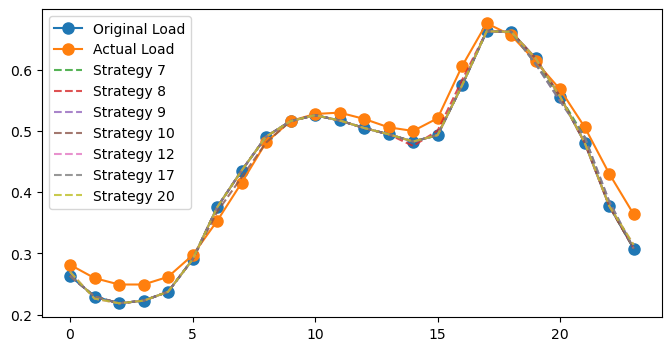

Found 0 relevant failed reflection cases for inquiry 0


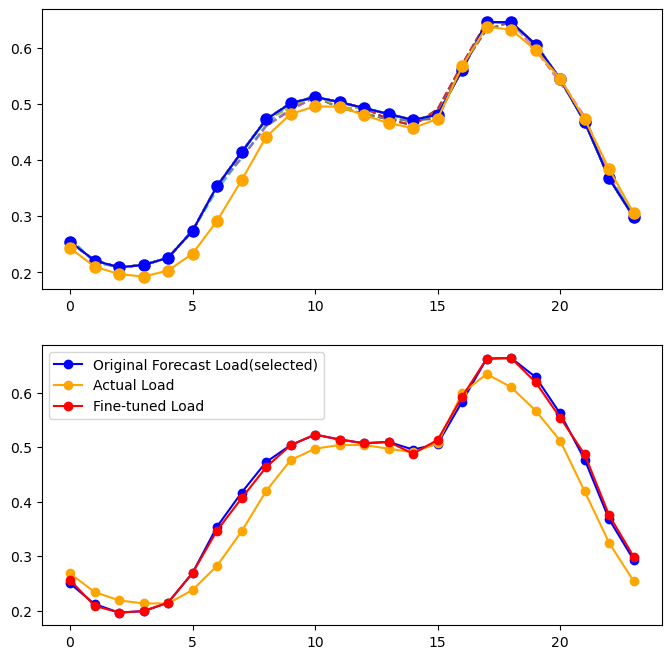

Original cost: 2544.6797387695315, Fine-tuned cost: 2530.9193639711975
The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 2/29
Found 3 similar days for inquiry 1
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_7, cost 2496.66, original cost 2500.05, (reduction 3.39)
Strategy generation attempt #2 (Current valid strategies: 1/20)
Discovered valid strategy strategy_1, cost 2498.57, original cost 2500.05, (reduction 1.49)
Discovered valid strategy strategy_8, cost 2497.26, original cost 2500.05, (reduction 2.80)
Strategy generation attempt #3 (Current valid strategies: 3/20)
Providing actual load values
Discovered valid strategy strategy_1, cost 2498.57, original cost 2500.05, (reducti

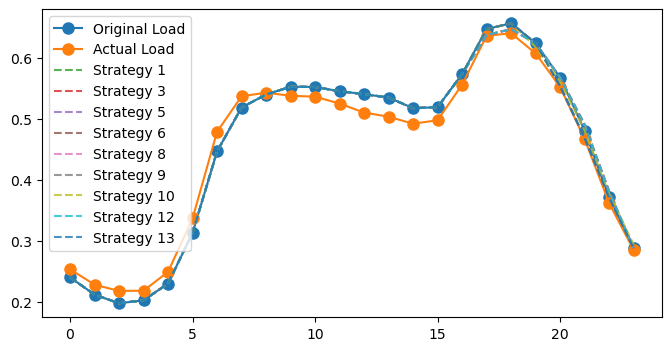

Found 0 relevant failed reflection cases for inquiry 1


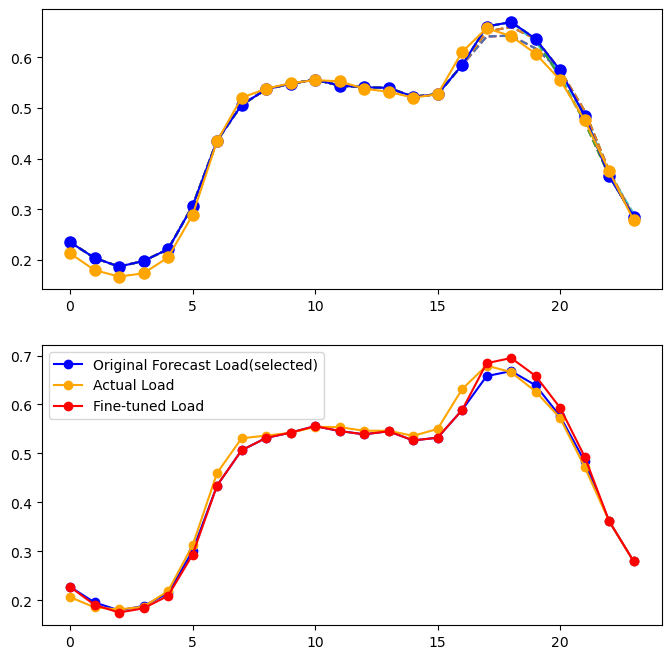

Original cost: 2565.0915869140626, Fine-tuned cost: 2583.454303311334
Strategy generation attempt #1 (Current valid strategies: 0/5)
Discovered valid strategy strategy_5, cost 2550.85, original cost 2565.09, (reduction 14.24)
Discovered valid strategy strategy_8, cost 2552.11, original cost 2565.09, (reduction 12.98)
Strategy generation attempt #2 (Current valid strategies: 2/5)
Providing actual load values
Discovered valid strategy strategy_2, cost 2549.45, original cost 2565.09, (reduction 15.64)
Discovered valid strategy strategy_3, cost 2561.89, original cost 2565.09, (reduction 3.20)
Discovered valid strategy strategy_4, cost 2552.30, original cost 2565.09, (reduction 12.79)
2554.885662841797
2557.186833641266


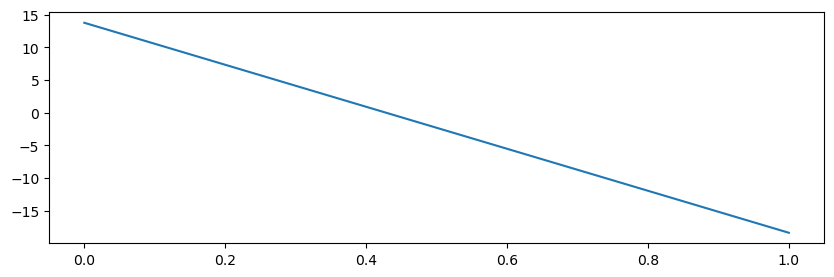

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 3/29
Found 3 similar days for inquiry 2
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_2, cost 2563.97, original cost 2571.27, (reduction 7.30)
Discovered valid strategy strategy_8, cost 2569.65, original cost 2571.27, (reduction 1.61)
Strategy generation attempt #2 (Current valid strategies: 2/20)
执行策略代码块失败: invalid syntax (<string>, line 1)
No valid strategy functions generated
Strategy generation attempt #3 (Current valid strategies: 2/20)
Providing actual load values
Discovered valid strategy strategy_1, cost 2566.36, original cost 2571.27, (reduction 4.90)
Strategy generation attempt #4 (Current valid strategies: 3/20)
Providi

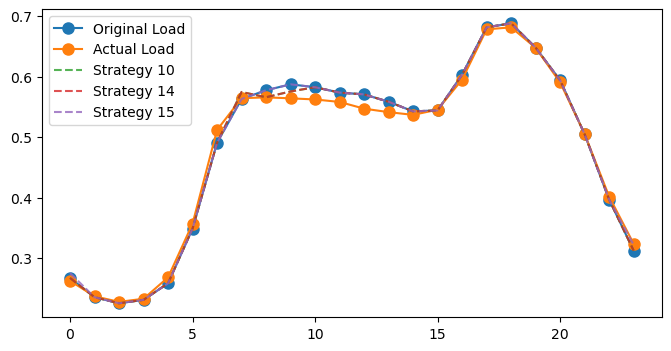

Found 1 relevant failed reflection cases for inquiry 2


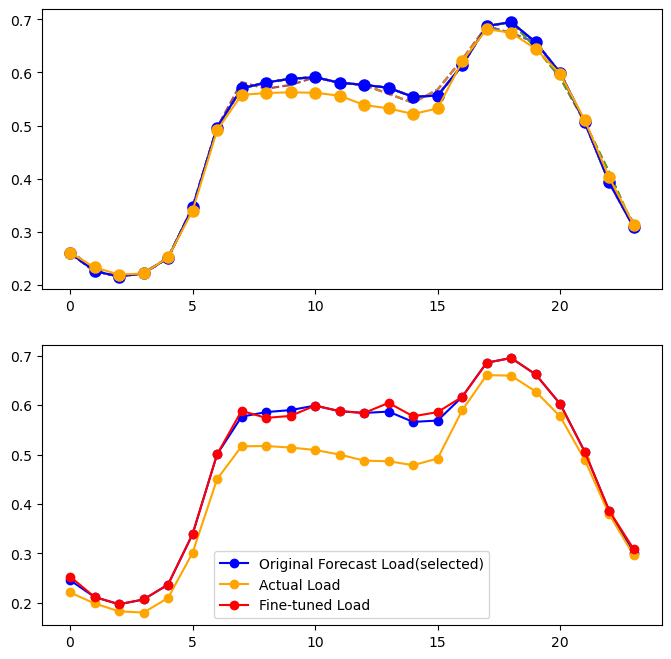

Original cost: 2672.1360458984377, Fine-tuned cost: 2685.4973495232043
Strategy generation attempt #1 (Current valid strategies: 0/5)
Discovered valid strategy strategy_1, cost 2659.44, original cost 2672.14, (reduction 12.69)
Discovered valid strategy strategy_4, cost 2661.31, original cost 2672.14, (reduction 10.83)
Discovered valid strategy strategy_10, cost 2663.47, original cost 2672.14, (reduction 8.67)
Strategy generation attempt #2 (Current valid strategies: 3/5)
Providing actual load values
Discovered valid strategy strategy_1, cost 2659.44, original cost 2672.14, (reduction 12.69)
Discovered valid strategy strategy_3, cost 2661.27, original cost 2672.14, (reduction 10.86)
2593.9691238606774
2599.957005601912


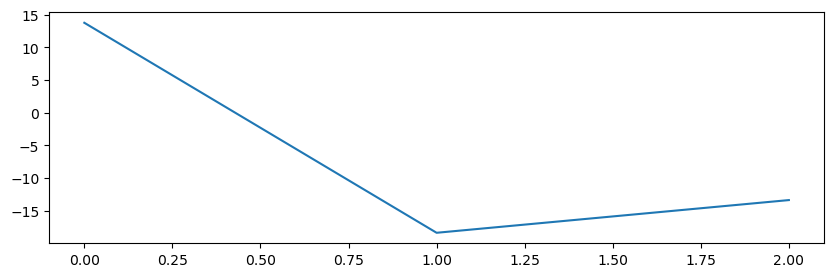

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 4/29
Found 3 similar days for inquiry 3
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_3, cost 2561.79, original cost 2574.45, (reduction 12.66)
Discovered valid strategy strategy_5, cost 2569.97, original cost 2574.45, (reduction 4.47)
Strategy generation attempt #2 (Current valid strategies: 2/20)
Discovered valid strategy strategy_5, cost 2564.45, original cost 2574.45, (reduction 10.00)
Strategy generation attempt #3 (Current valid strategies: 3/20)
Providing actual load values
Discovered valid strategy strategy_5, cost 2567.14, original cost 2574.45, (reduction 7.31)
Discovered valid strategy strategy_8, cost 2559.94, original

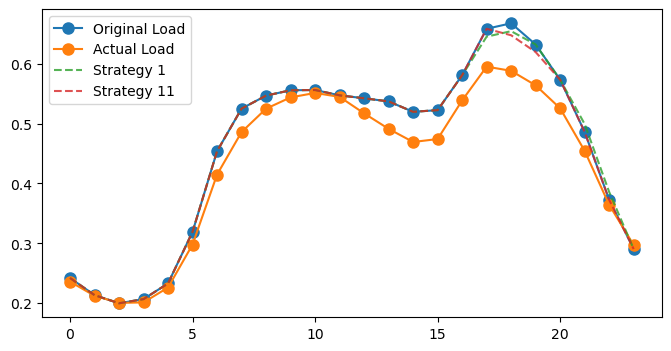

Found 1 relevant failed reflection cases for inquiry 3


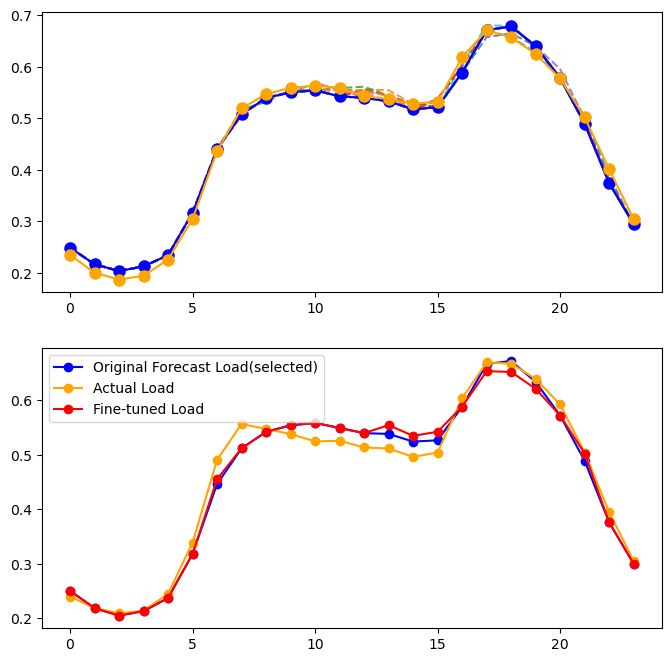

Original cost: 2630.5475029296877, Fine-tuned cost: 2654.0571580472056
Strategy generation attempt #1 (Current valid strategies: 0/5)
Discovered valid strategy strategy_8, cost 2614.65, original cost 2630.55, (reduction 15.90)
Strategy generation attempt #2 (Current valid strategies: 1/5)
Providing actual load values
Discovered valid strategy strategy_6, cost 2616.76, original cost 2630.55, (reduction 13.78)
Discovered valid strategy strategy_8, cost 2614.65, original cost 2630.55, (reduction 15.90)
Strategy generation attempt #3 (Current valid strategies: 3/5)
Providing actual load values
Discovered valid strategy strategy_2, cost 2625.73, original cost 2630.55, (reduction 4.82)
Discovered valid strategy strategy_5, cost 2624.36, original cost 2630.55, (reduction 6.19)
2603.11371862793
2613.4820437132353


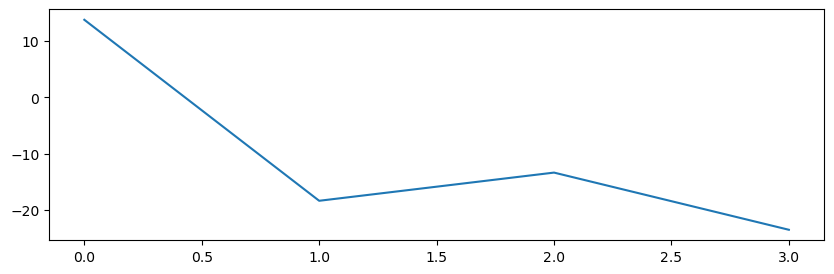

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 5/29
Found 3 similar days for inquiry 4
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_7, cost 2565.94, original cost 2601.59, (reduction 35.64)
Discovered valid strategy strategy_10, cost 2600.35, original cost 2601.59, (reduction 1.24)
Strategy generation attempt #2 (Current valid strategies: 2/20)
Discovered valid strategy strategy_5, cost 2599.97, original cost 2601.59, (reduction 1.62)
Discovered valid strategy strategy_6, cost 2599.42, original cost 2601.59, (reduction 2.17)
Discovered valid strategy strategy_7, cost 2565.94, original cost 2601.59, (reduction 35.64)
Discovered valid strategy strategy_10, cost 2600.35, origina

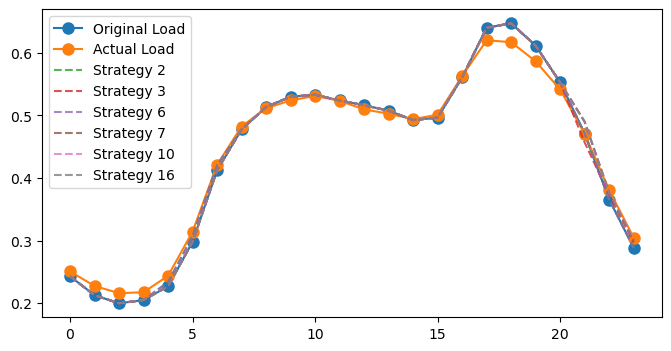

Found 1 relevant failed reflection cases for inquiry 4


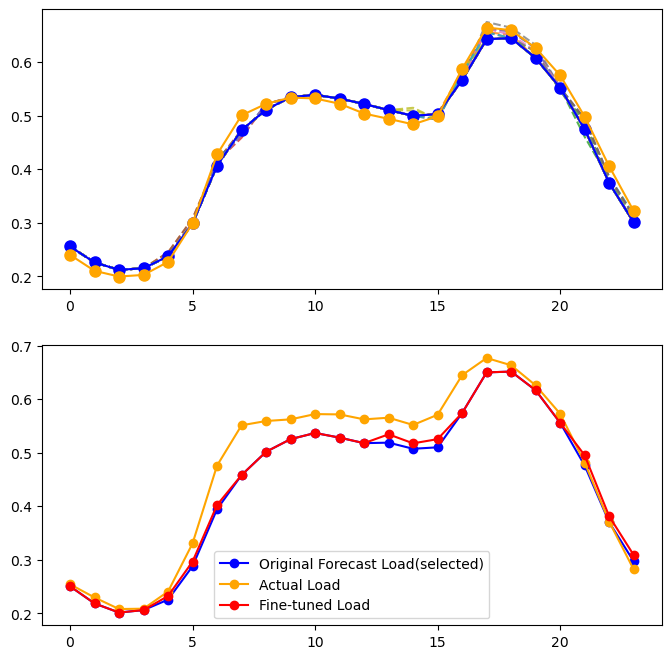

Original cost: 3008.7997490234375, Fine-tuned cost: 2967.396131637606
2684.2509247070316
2684.2648612981093


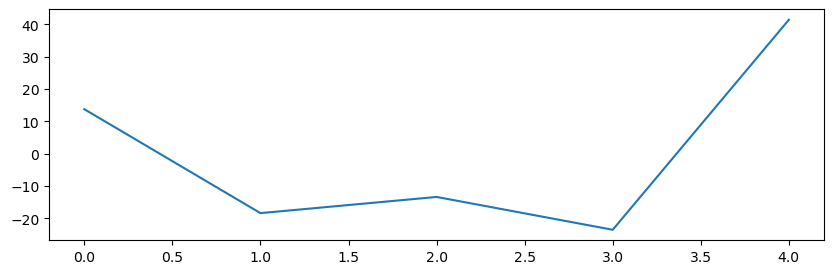

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 6/29
Found 3 similar days for inquiry 5
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2377.83, original cost 2390.97, (reduction 13.14)
Discovered valid strategy strategy_4, cost 2388.18, original cost 2390.97, (reduction 2.79)
Discovered valid strategy strategy_7, cost 2383.37, original cost 2390.97, (reduction 7.60)
Discovered valid strategy strategy_10, cost 2388.50, original cost 2390.97, (reduction 2.47)
Strategy generation attempt #2 (Current valid strategies: 4/20)
Discovered valid strategy strategy_1, cost 2377.83, original cost 2390.97, (reduction 13.14)
Discovered valid strategy strategy_3, cost 2387.61, original

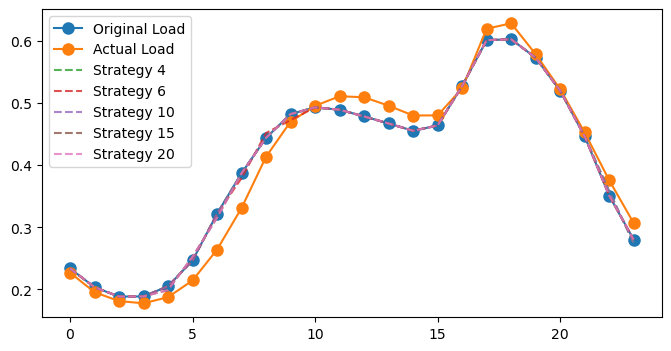

Found 1 relevant failed reflection cases for inquiry 5


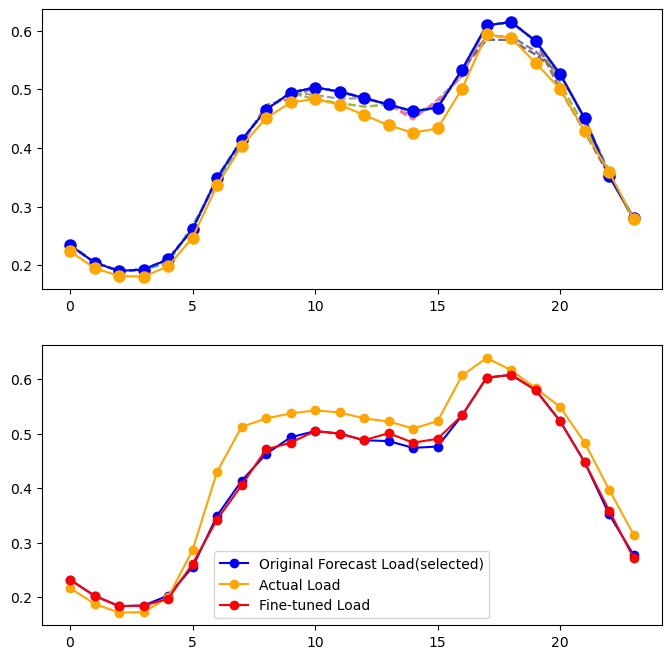

Original cost: 2984.539114257812, Fine-tuned cost: 2963.8660182965687
2734.298956298828
2730.865054131186


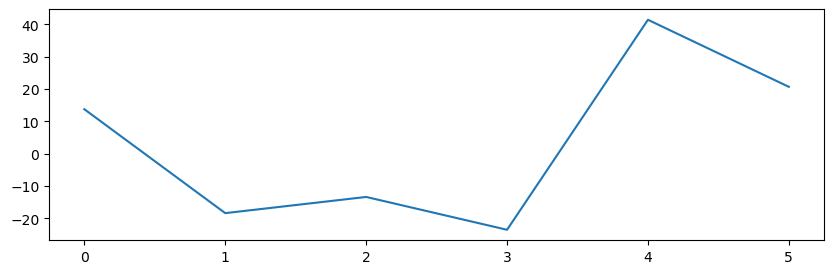

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 7/29
Found 3 similar days for inquiry 6
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_4, cost 2410.78, original cost 2413.62, (reduction 2.84)
Discovered valid strategy strategy_5, cost 2395.02, original cost 2413.62, (reduction 18.60)
Discovered valid strategy strategy_8, cost 2410.58, original cost 2413.62, (reduction 3.04)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_4, cost 2405.67, original cost 2413.62, (reduction 7.95)
Discovered valid strategy strategy_5, cost 2412.61, original cost 2413.62, (reduction 1.01)
Discovered valid strategy strategy_7, cost 2404.32, original c

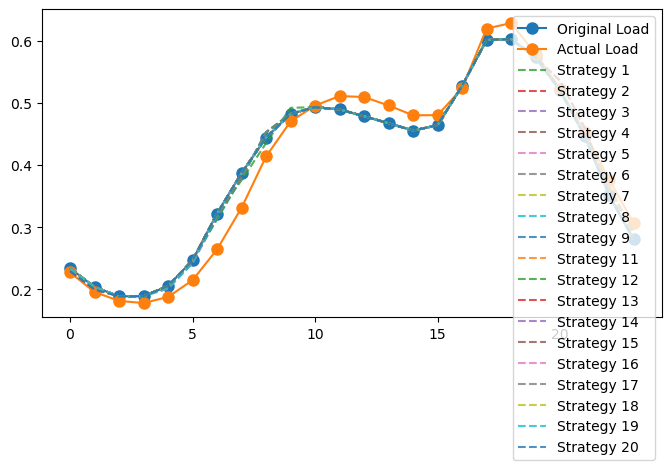

Found 1 relevant failed reflection cases for inquiry 6


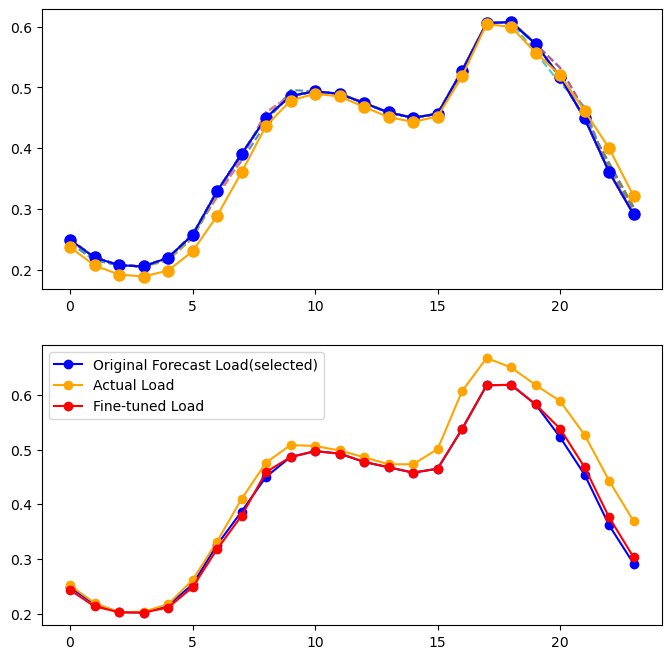

Original cost: 2842.0847583007812, Fine-tuned cost: 2821.0239606604337
2749.696928013393
2743.7448979210785


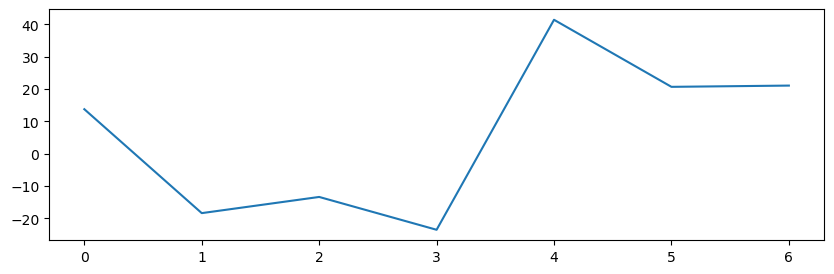

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 8/29
Found 3 similar days for inquiry 7
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
执行策略代码块失败: invalid syntax (<string>, line 1)
No valid strategy functions generated
Strategy generation attempt #2 (Current valid strategies: 0/20)
Discovered valid strategy strategy_2, cost 2572.81, original cost 2581.15, (reduction 8.34)
Discovered valid strategy strategy_3, cost 2570.38, original cost 2581.15, (reduction 10.77)
Discovered valid strategy strategy_6, cost 2577.67, original cost 2581.15, (reduction 3.49)
Discovered valid strategy strategy_8, cost 2572.45, original cost 2581.15, (reduction 8.70)
Strategy generation attempt #3 (Current valid strategies: 4/20)
Providi

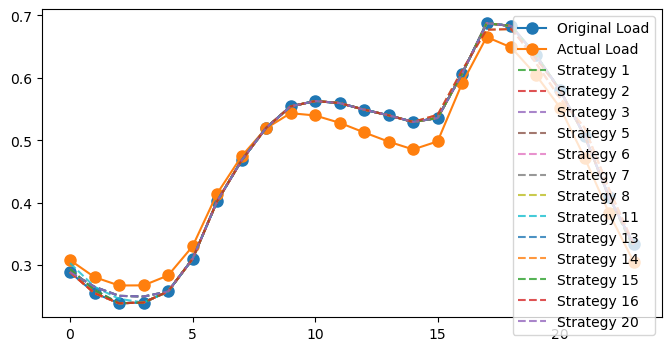

Found 1 relevant failed reflection cases for inquiry 7


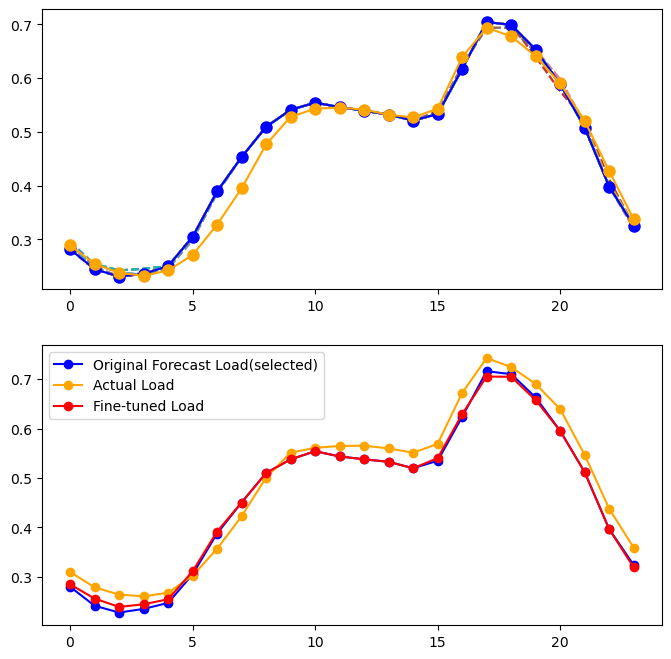

Original cost: 2929.290492675781, Fine-tuned cost: 2908.9838898011562
2772.1461235961915
2764.3997719060885


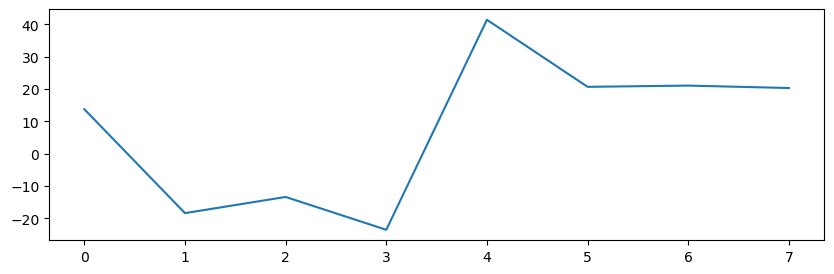

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 9/29
Found 3 similar days for inquiry 8
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2705.32, original cost 2721.18, (reduction 15.87)
Discovered valid strategy strategy_4, cost 2709.53, original cost 2721.18, (reduction 11.65)
Discovered valid strategy strategy_5, cost 2717.90, original cost 2721.18, (reduction 3.28)
Discovered valid strategy strategy_8, cost 2718.94, original cost 2721.18, (reduction 2.24)
Strategy generation attempt #2 (Current valid strategies: 4/20)
Discovered valid strategy strategy_1, cost 2706.07, original cost 2721.18, (reduction 15.11)
Discovered valid strategy strategy_4, cost 2714.52, original

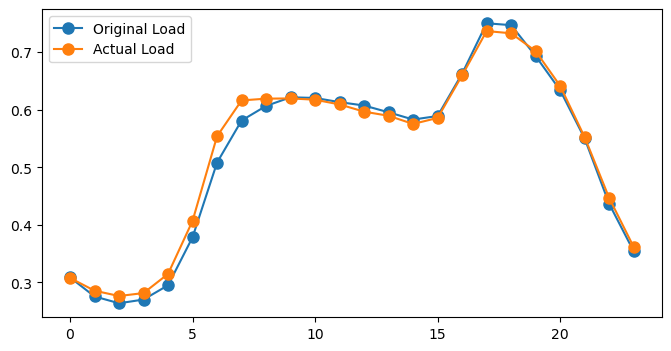

Inquiry 8: No valid strategy found, using original curve as fine-tuned result.
2807.9041499565974
2801.018504009839


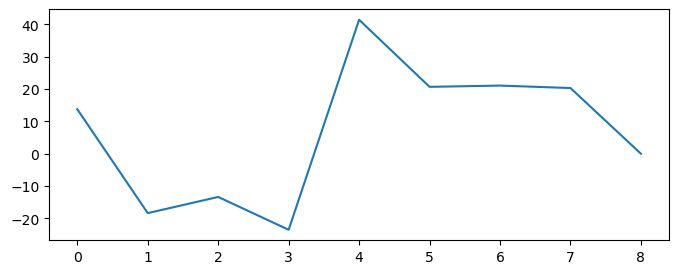

Processing inquiry 10/29
Found 3 similar days for inquiry 9
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2732.27, original cost 2751.02, (reduction 18.75)
Discovered valid strategy strategy_6, cost 2747.84, original cost 2751.02, (reduction 3.18)
Discovered valid strategy strategy_9, cost 2739.46, original cost 2751.02, (reduction 11.56)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_1, cost 2732.27, original cost 2751.02, (reduction 18.75)
Discovered valid strategy strategy_4, cost 2739.66, original cost 2751.02, (reduction 11.36)
Discovered valid strategy strategy_5, cost 2745.35, original cost 2751.02, (reduction 5.67)
Discovered valid strategy strategy_6, cost 2747.84, original cost 2751.02, (reduction 3.18)
Discovered valid strategy strategy_7, cost 2748.73, original cost 2751.02, (reduction 2.29)
Discovered valid st

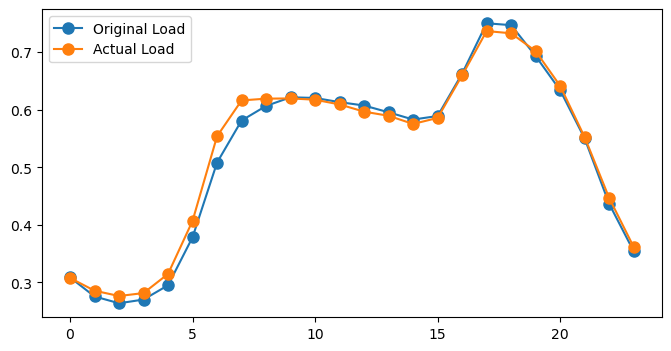

Inquiry 9: No valid strategy found, using original curve as fine-tuned result.
2822.313160058594
2816.1160787065114


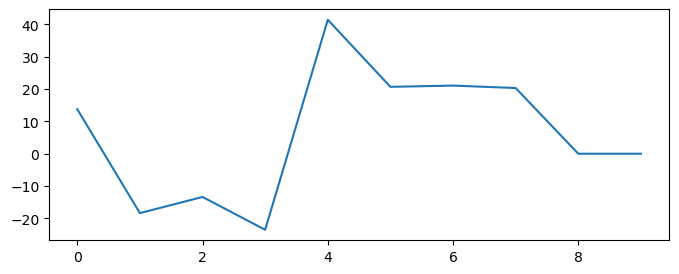

Processing inquiry 11/29
Found 3 similar days for inquiry 10
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2703.51, original cost 2721.18, (reduction 17.67)
Discovered valid strategy strategy_4, cost 2709.02, original cost 2721.18, (reduction 12.16)
Discovered valid strategy strategy_10, cost 2712.94, original cost 2721.18, (reduction 8.25)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_1, cost 2703.51, original cost 2721.18, (reduction 17.67)
Discovered valid strategy strategy_4, cost 2709.02, original cost 2721.18, (reduction 12.16)
Discovered valid strategy strategy_5, cost 2715.02, original cost 2721.18, (reduction 6.16)
Discovered valid strategy strategy_8, cost 2715.47, original cost 2721.18, (reduction 5.72)
Discovered valid strategy strategy_9, cost 2714.78, original cost 2721.18, (reduction 6.40)
Discovered valid 

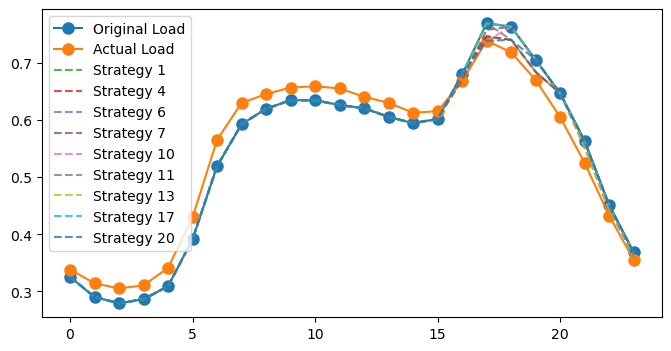

Found 1 relevant failed reflection cases for inquiry 10


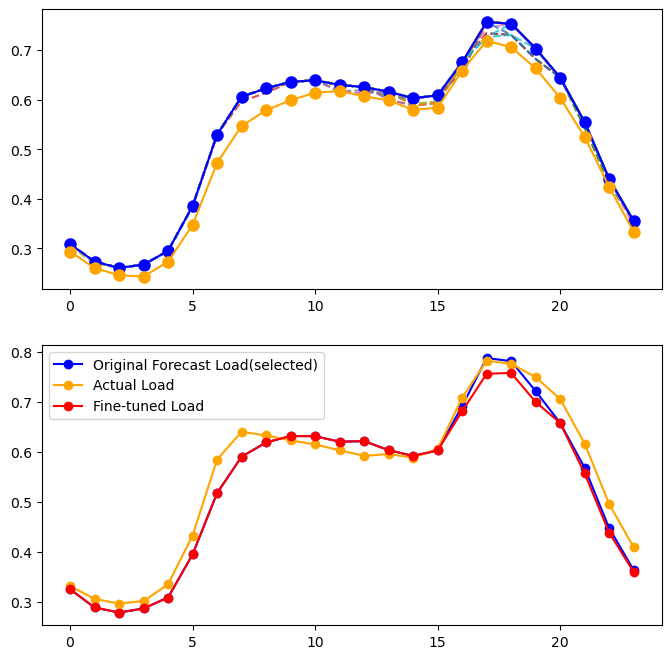

Original cost: 3034.003692382812, Fine-tuned cost: 3102.1794203620016
Strategy generation attempt #1 (Current valid strategies: 0/5)
执行策略代码块失败: invalid syntax (<string>, line 1)
No valid strategy functions generated
Strategy generation attempt #2 (Current valid strategies: 0/5)
Providing actual load values
Discovered valid strategy strategy_3, cost 3032.32, original cost 3034.00, (reduction 1.68)
Discovered valid strategy strategy_5, cost 3015.63, original cost 3034.00, (reduction 18.37)
Discovered valid strategy strategy_8, cost 3031.69, original cost 3034.00, (reduction 2.31)
Discovered valid strategy strategy_10, cost 3030.61, original cost 3034.00, (reduction 3.39)
Strategy generation attempt #3 (Current valid strategies: 4/5)
Providing actual load values
Discovered valid strategy strategy_2, cost 3015.45, original cost 3034.00, (reduction 18.56)
2841.55775390625
2842.1218370388287


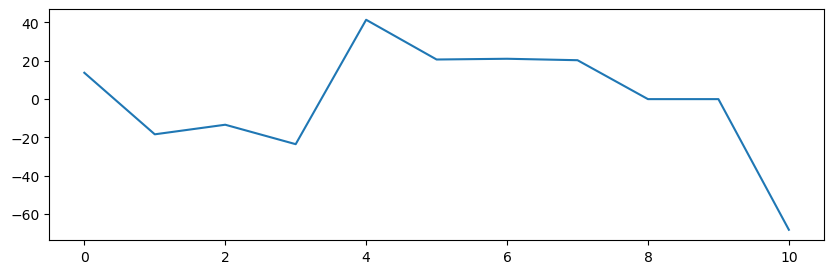

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [8, 9]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 12/29
Found 3 similar days for inquiry 11
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2798.56, original cost 2816.96, (reduction 18.40)
Discovered valid strategy strategy_2, cost 2793.50, original cost 2816.96, (reduction 23.45)
Discovered valid strategy strategy_4, cost 2813.43, original cost 2816.96, (reduction 3.52)
Discovered valid strategy strategy_5, cost 2811.49, original cost 2816.96, (reduction 5.47)
Discovered valid strategy strategy_8, cost 2811.99, original cost 2816.96, (reduction 4.97)
Strategy generation attempt #2 (Current valid strategies: 5/20)
Discovered valid strategy strategy_1, cost 2798.56, ori

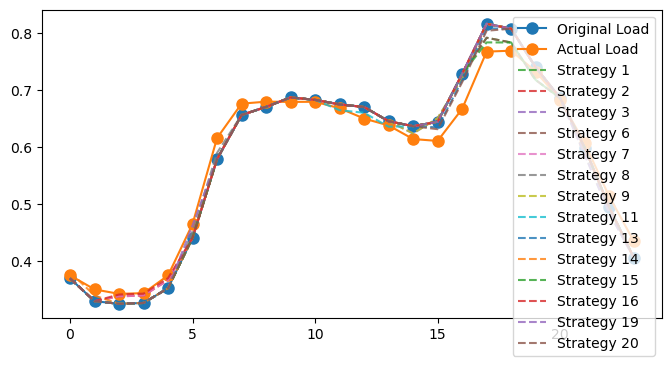

Found 1 relevant failed reflection cases for inquiry 11


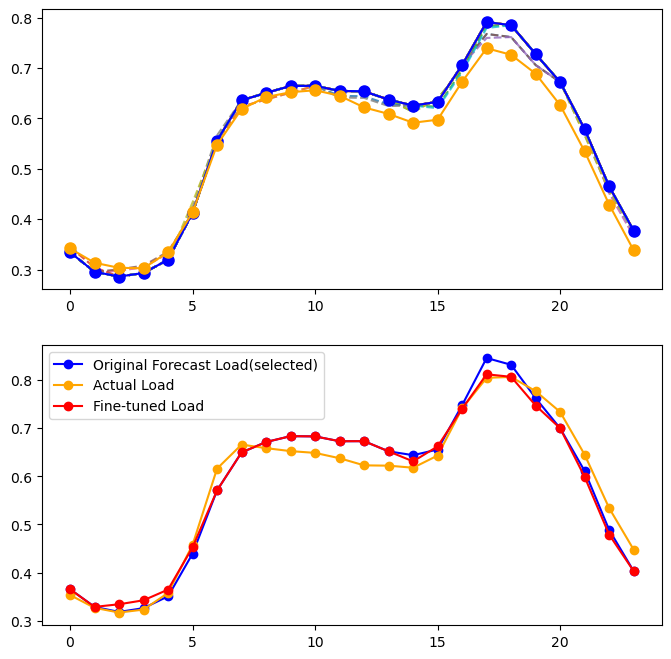

Original cost: 3002.473008789062, Fine-tuned cost: 3006.12782334457
Strategy generation attempt #1 (Current valid strategies: 0/5)
Discovered valid strategy strategy_1, cost 2986.83, original cost 3002.47, (reduction 15.64)
Discovered valid strategy strategy_3, cost 2999.59, original cost 3002.47, (reduction 2.88)
Discovered valid strategy strategy_5, cost 2993.58, original cost 3002.47, (reduction 8.90)
Discovered valid strategy strategy_8, cost 2989.61, original cost 3002.47, (reduction 12.86)
Strategy generation attempt #2 (Current valid strategies: 4/5)
Providing actual load values
Discovered valid strategy strategy_1, cost 2986.83, original cost 3002.47, (reduction 15.64)
2854.967358479818
2855.789002564307


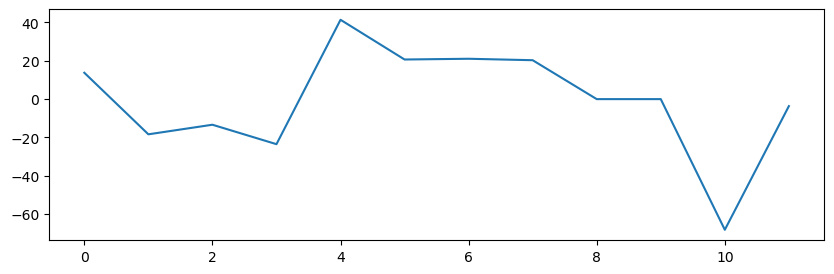

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [8, 9]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 13/29
Found 3 similar days for inquiry 12
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2798.56, original cost 2816.96, (reduction 18.40)
Discovered valid strategy strategy_3, cost 2793.50, original cost 2816.96, (reduction 23.45)
Discovered valid strategy strategy_5, cost 2809.57, original cost 2816.96, (reduction 7.38)
Discovered valid strategy strategy_6, cost 2810.60, original cost 2816.96, (reduction 6.36)
Discovered valid strategy strategy_7, cost 2815.87, original cost 2816.96, (reduction 1.09)
Discovered valid strategy strategy_8, cost 2815.04, original cost 2816.96, (reduction 1.92)
Discovered valid strategy s

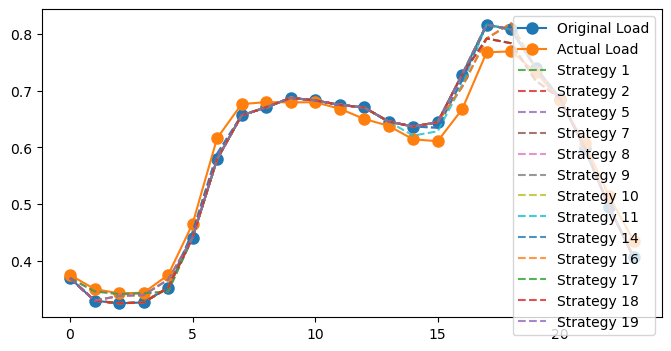

Found 1 relevant failed reflection cases for inquiry 12


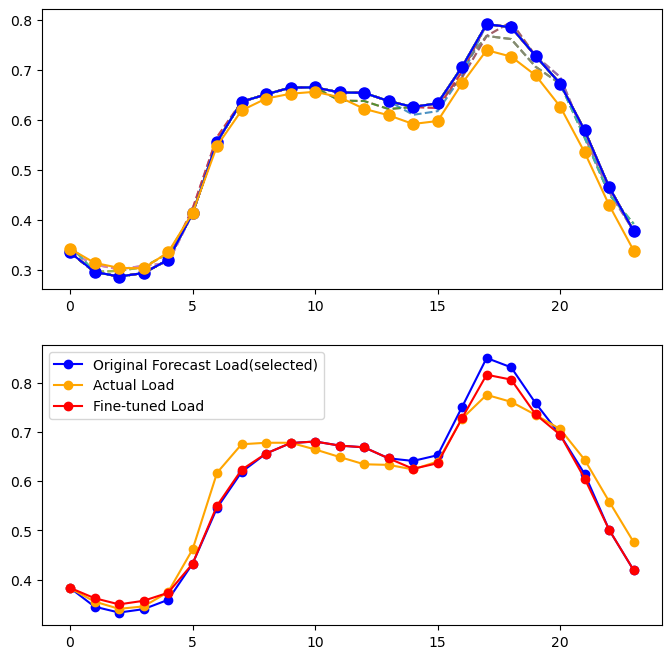

Original cost: 3093.523514160156, Fine-tuned cost: 3040.6410161109447
2873.31783199369
2870.008388221741


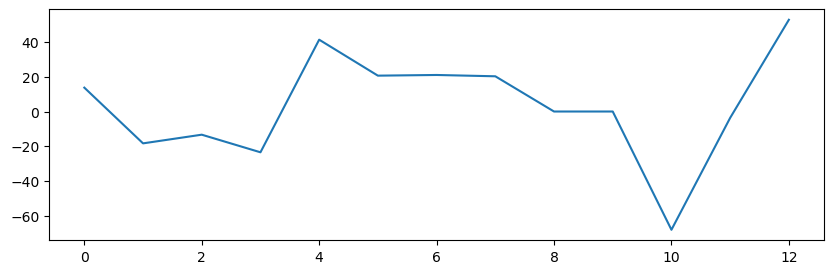

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [8, 9]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 14/29
Found 3 similar days for inquiry 13
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2728.71, original cost 2746.98, (reduction 18.27)
Discovered valid strategy strategy_2, cost 2737.03, original cost 2746.98, (reduction 9.95)
Discovered valid strategy strategy_3, cost 2739.29, original cost 2746.98, (reduction 7.69)
Discovered valid strategy strategy_4, cost 2739.00, original cost 2746.98, (reduction 7.98)
Discovered valid strategy strategy_6, cost 2737.31, original cost 2746.98, (reduction 9.67)
Discovered valid strategy strategy_7, cost 2733.85, original cost 2746.98, (reduction 13.13)
Strategy generation attempt

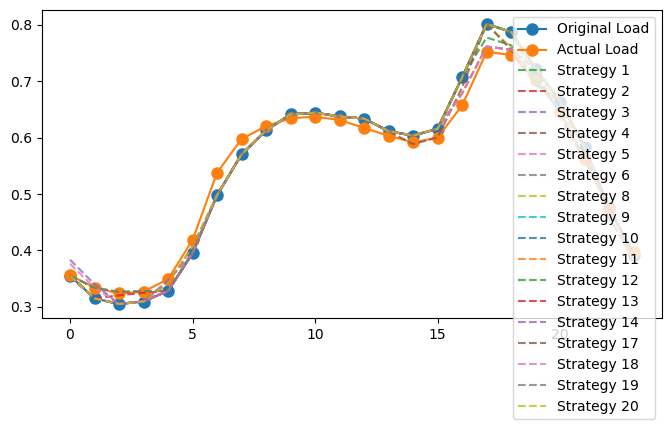

Found 1 relevant failed reflection cases for inquiry 13


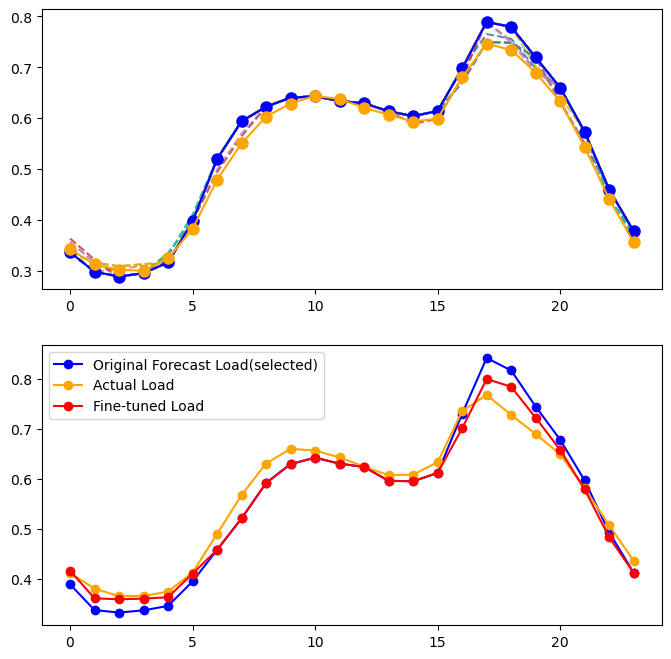

Original cost: 3062.3299511718747, Fine-tuned cost: 2969.7740890871046
2886.818697649275
2877.134509712124


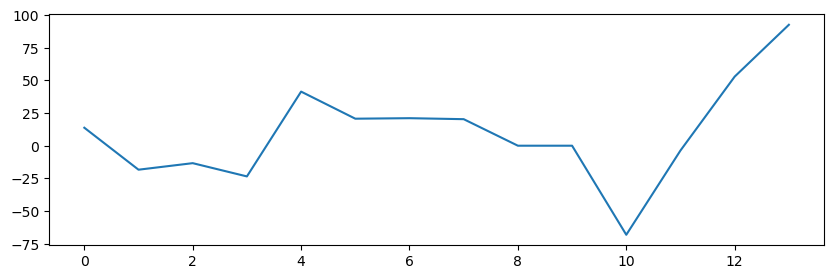

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [8, 9]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 15/29
Found 3 similar days for inquiry 14
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2686.05, original cost 2699.94, (reduction 13.89)
Discovered valid strategy strategy_3, cost 2698.03, original cost 2699.94, (reduction 1.91)
Discovered valid strategy strategy_4, cost 2696.46, original cost 2699.94, (reduction 3.49)
Discovered valid strategy strategy_7, cost 2698.08, original cost 2699.94, (reduction 1.86)
Strategy generation attempt #2 (Current valid strategies: 4/20)
Discovered valid strategy strategy_1, cost 2686.18, original cost 2699.94, (reduction 13.76)
Discovered valid strategy strategy_2, cost 2697.80, ori

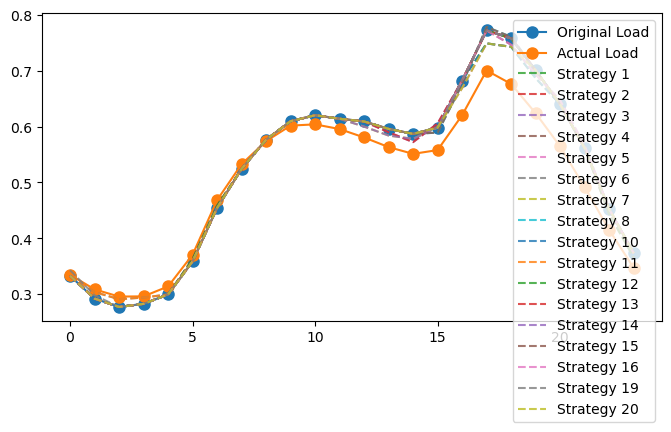

Found 1 relevant failed reflection cases for inquiry 14


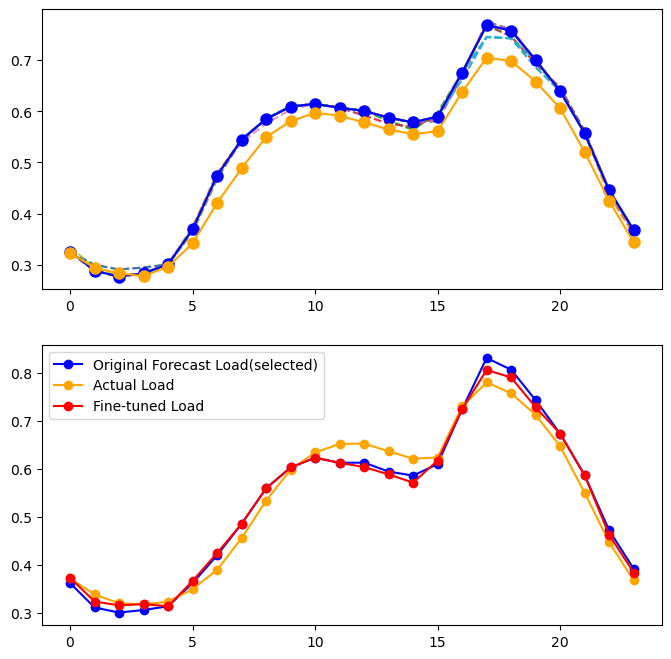

Original cost: 2887.7637436523437, Fine-tuned cost: 2852.274296383511
2886.881700716146
2875.477162156883


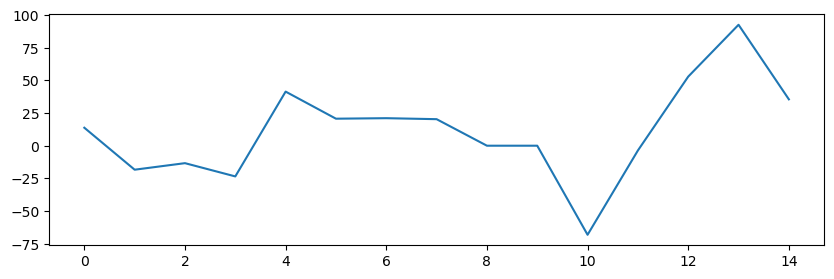

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [8, 9]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 16/29
Found 3 similar days for inquiry 15
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
执行策略代码块失败: invalid syntax (<string>, line 1)
No valid strategy functions generated
Strategy generation attempt #2 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2796.62, original cost 2816.96, (reduction 20.33)
Discovered valid strategy strategy_2, cost 2792.15, original cost 2816.96, (reduction 24.81)
Discovered valid strategy strategy_5, cost 2812.58, original cost 2816.96, (reduction 4.38)
Discovered valid strategy strategy_6, cost 2803.51, original cost 2816.96, (reduction 13.45)
Discovered valid strategy strategy_8, cost 2805.31, original co

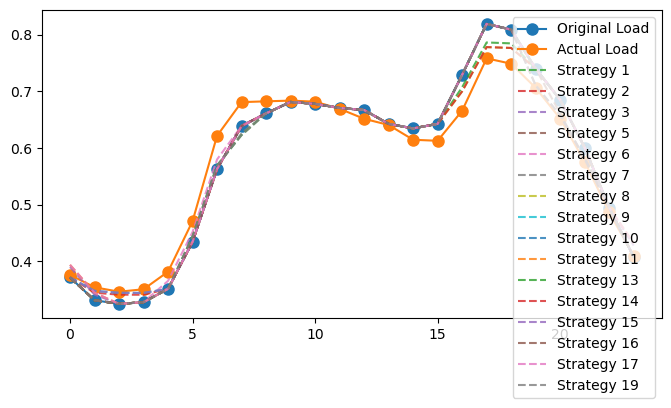

Found 1 relevant failed reflection cases for inquiry 15


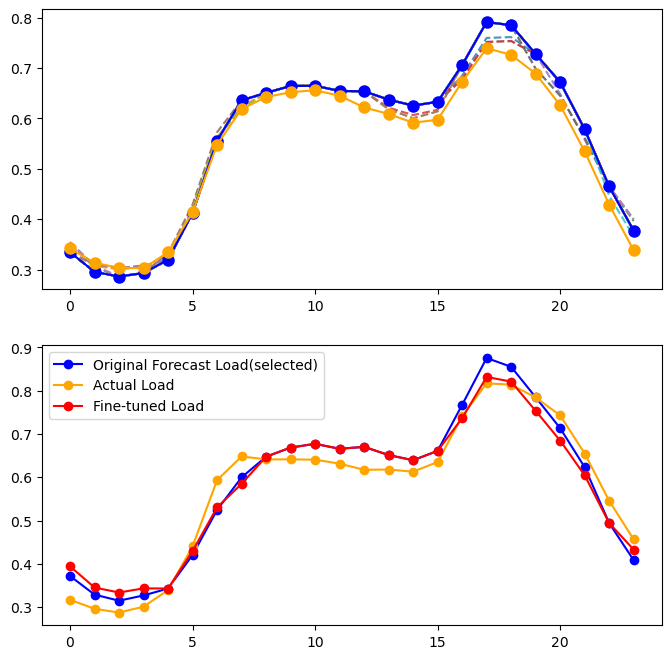

Original cost: 3061.2154790039062, Fine-tuned cost: 3093.4766562560767
Strategy generation attempt #1 (Current valid strategies: 0/5)
Discovered valid strategy strategy_1, cost 3038.95, original cost 3061.22, (reduction 22.27)
Discovered valid strategy strategy_3, cost 3055.20, original cost 3061.22, (reduction 6.01)
Discovered valid strategy strategy_5, cost 3051.46, original cost 3061.22, (reduction 9.75)
Discovered valid strategy strategy_6, cost 3048.45, original cost 3061.22, (reduction 12.76)
Discovered valid strategy strategy_7, cost 3052.77, original cost 3061.22, (reduction 8.45)
2897.777561859131
2889.1021305380827


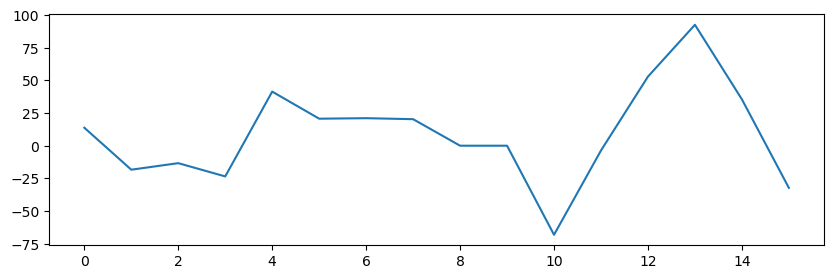

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [8, 9]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 17/29
Found 3 similar days for inquiry 16
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2904.96, original cost 2925.52, (reduction 20.56)
Discovered valid strategy strategy_2, cost 2917.08, original cost 2925.52, (reduction 8.44)
Discovered valid strategy strategy_4, cost 2922.94, original cost 2925.52, (reduction 2.58)
Discovered valid strategy strategy_6, cost 2916.26, original cost 2925.52, (reduction 9.27)
Discovered valid strategy strategy_8, cost 2909.40, original cost 2925.52, (reduction 16.12)
Discovered valid strategy strategy_9, cost 2914.62, original cost 2925.52, (reduction 10.90)
Discovered valid strategy 

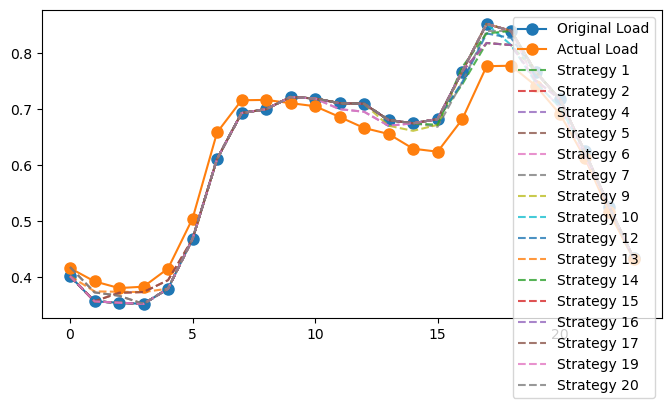

Found 1 relevant failed reflection cases for inquiry 16


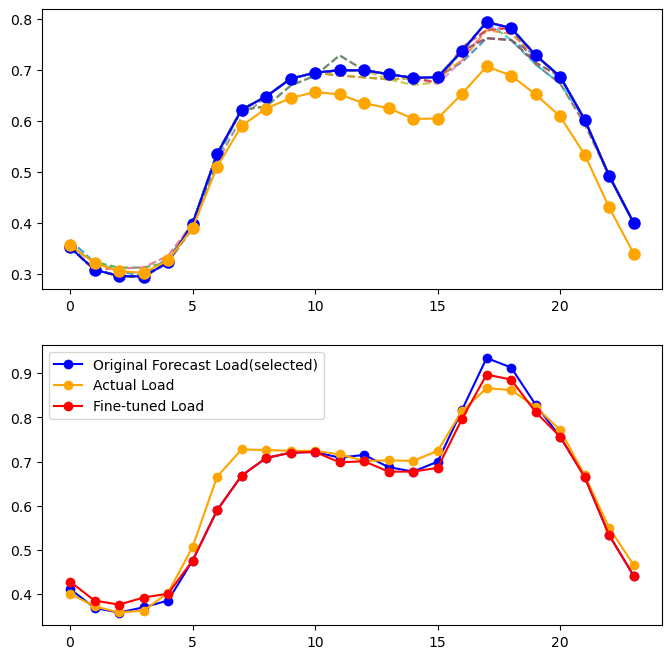

Original cost: 3159.699133300782, Fine-tuned cost: 3187.199046972174
Strategy generation attempt #1 (Current valid strategies: 0/5)
Discovered valid strategy strategy_1, cost 3148.36, original cost 3159.70, (reduction 11.34)
Discovered valid strategy strategy_6, cost 3142.86, original cost 3159.70, (reduction 16.84)
Discovered valid strategy strategy_8, cost 3157.69, original cost 3159.70, (reduction 2.01)
Discovered valid strategy strategy_10, cost 3147.42, original cost 3159.70, (reduction 12.28)
Strategy generation attempt #2 (Current valid strategies: 4/5)
Providing actual load values
Discovered valid strategy strategy_1, cost 3149.30, original cost 3159.70, (reduction 10.40)
2913.1847131204045
2906.6372432695


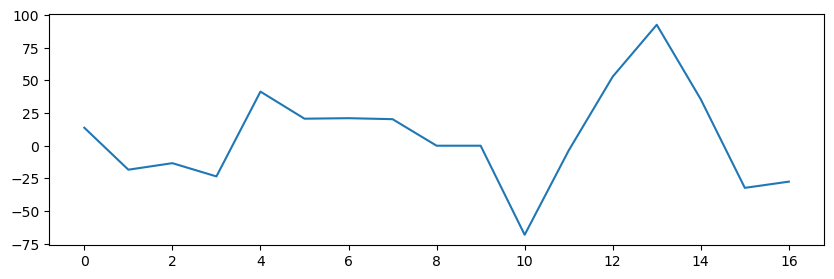

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [8, 9]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 18/29
Found 3 similar days for inquiry 17
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2907.14, original cost 2925.52, (reduction 18.38)
Discovered valid strategy strategy_2, cost 2914.79, original cost 2925.52, (reduction 10.73)
Discovered valid strategy strategy_3, cost 2922.93, original cost 2925.52, (reduction 2.59)
Discovered valid strategy strategy_5, cost 2911.82, original cost 2925.52, (reduction 13.70)
Discovered valid strategy strategy_6, cost 2911.86, original cost 2925.52, (reduction 13.66)
Discovered valid strategy strategy_7, cost 2918.51, original cost 2925.52, (reduction 7.01)
Discovered valid strategy

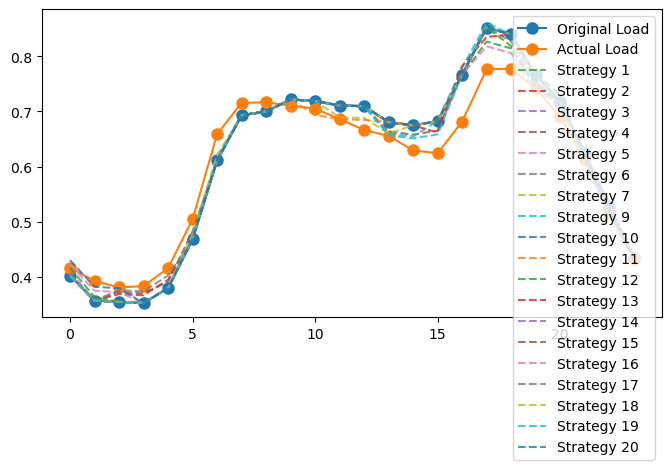

Found 1 relevant failed reflection cases for inquiry 17


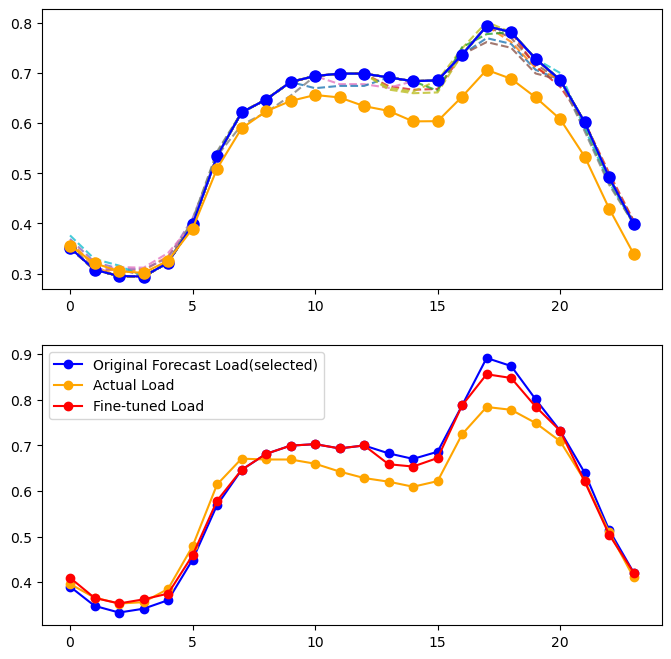

Original cost: 3068.5172119140625, Fine-tuned cost: 2976.746127062786
2921.814296386719
2910.5321812580155


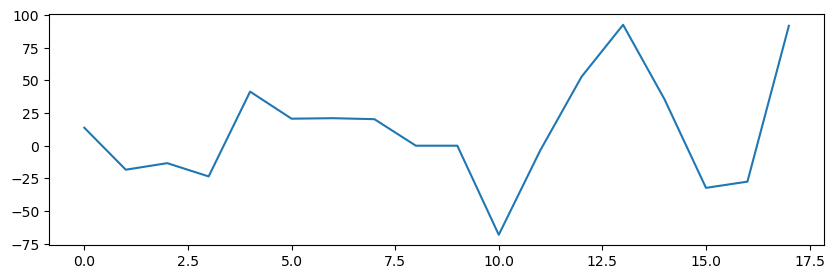

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [8, 9]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 19/29
Found 3 similar days for inquiry 18
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2732.70, original cost 2746.98, (reduction 14.28)
Discovered valid strategy strategy_3, cost 2731.09, original cost 2746.98, (reduction 15.89)
Discovered valid strategy strategy_4, cost 2744.75, original cost 2746.98, (reduction 2.23)
Discovered valid strategy strategy_5, cost 2742.14, original cost 2746.98, (reduction 4.84)
Discovered valid strategy strategy_8, cost 2740.64, original cost 2746.98, (reduction 6.34)
Discovered valid strategy strategy_9, cost 2743.37, original cost 2746.98, (reduction 3.61)
Discovered valid strategy s

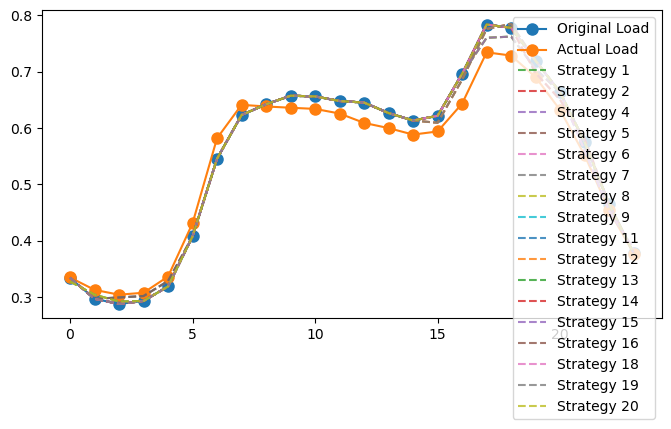

Found 1 relevant failed reflection cases for inquiry 18


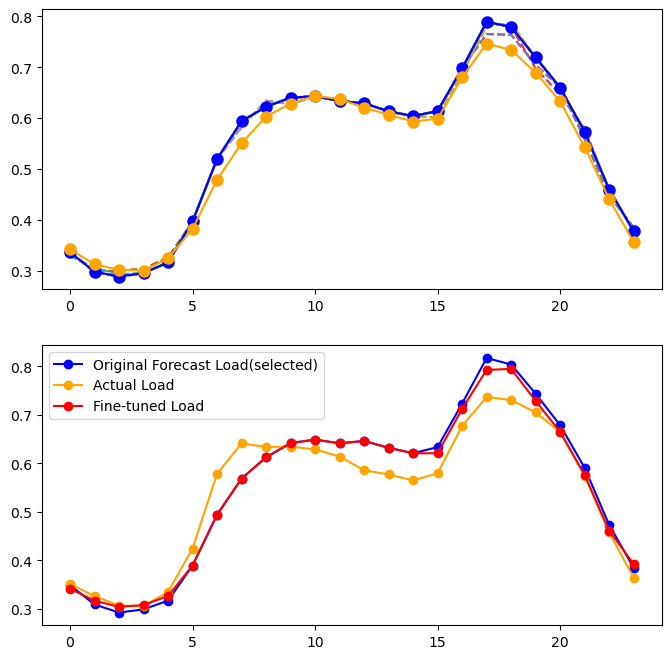

Original cost: 2977.098112792969, Fine-tuned cost: 2929.577682359405
2924.7239709344162
2911.5345760528253


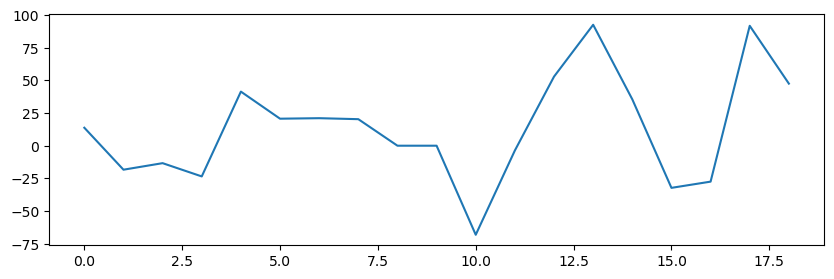

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [8, 9]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 20/29
Found 3 similar days for inquiry 19
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
执行策略代码块失败: invalid syntax (<string>, line 1)
No valid strategy functions generated
Strategy generation attempt #2 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2666.49, original cost 2685.61, (reduction 19.12)
Discovered valid strategy strategy_4, cost 2684.05, original cost 2685.61, (reduction 1.56)
Discovered valid strategy strategy_5, cost 2675.59, original cost 2685.61, (reduction 10.01)
Discovered valid strategy strategy_6, cost 2682.39, original cost 2685.61, (reduction 3.22)
Strategy generation attempt #3 (Current valid strategies: 4/20)


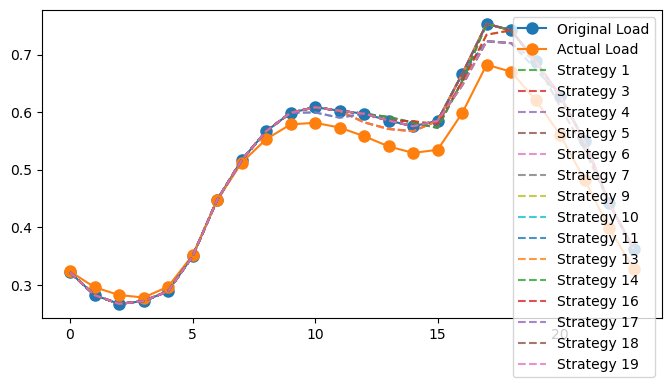

Found 1 relevant failed reflection cases for inquiry 19


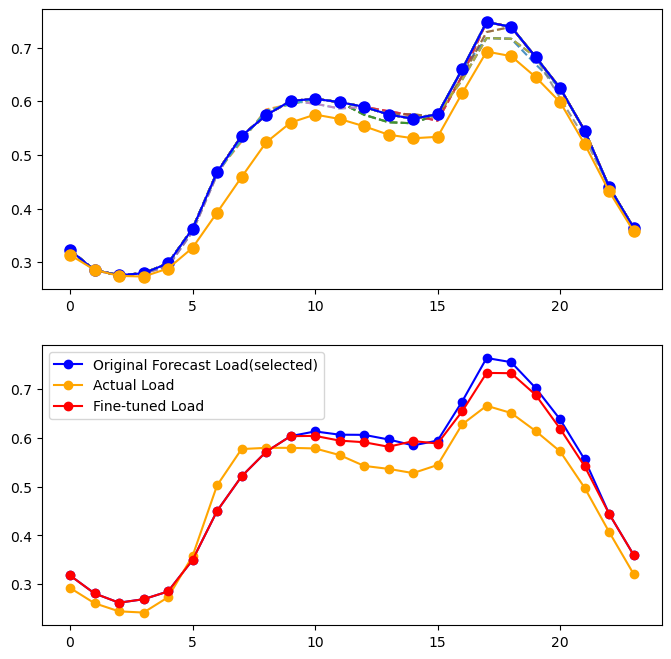

Original cost: 2828.135686523438, Fine-tuned cost: 2783.1340086252662
2919.8945567138676
2905.1145476814477


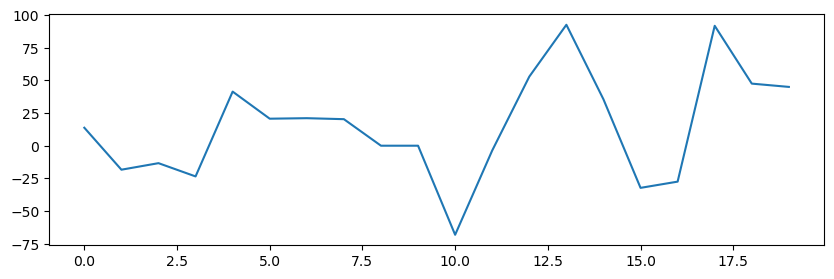

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [8, 9]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 21/29
Found 3 similar days for inquiry 20
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_4, cost 2558.60, original cost 2573.85, (reduction 15.25)
Discovered valid strategy strategy_9, cost 2566.62, original cost 2573.85, (reduction 7.23)
Strategy generation attempt #2 (Current valid strategies: 2/20)
Discovered valid strategy strategy_4, cost 2557.06, original cost 2573.85, (reduction 16.79)
Strategy generation attempt #3 (Current valid strategies: 3/20)
Providing actual load values
执行策略代码块失败: invalid syntax (<string>, line 1)
No valid strategy functions generated
Strategy generation attempt #4 (Current valid strategies: 3/20)

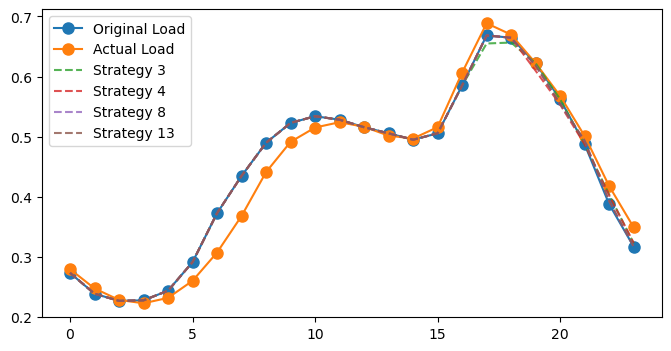

Found 1 relevant failed reflection cases for inquiry 20


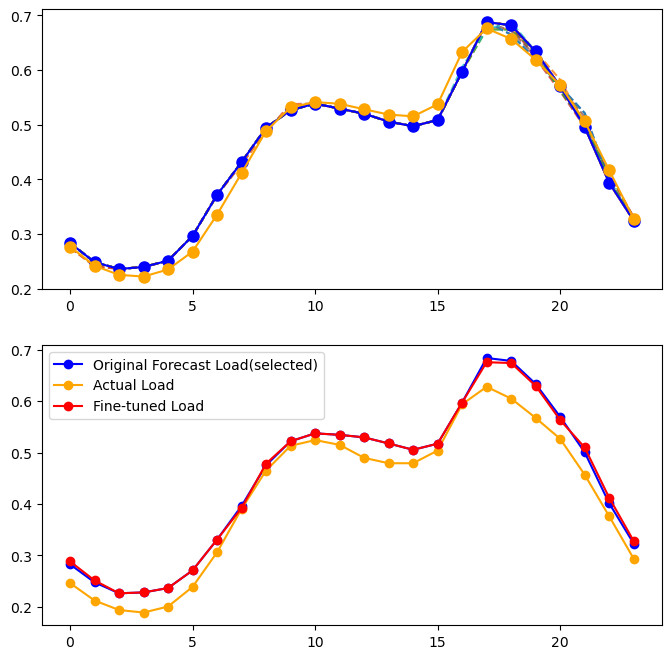

Original cost: 2520.8567573242185, Fine-tuned cost: 2524.4108993125706
Strategy generation attempt #1 (Current valid strategies: 0/5)
Discovered valid strategy strategy_1, cost 2508.17, original cost 2520.86, (reduction 12.69)
Strategy generation attempt #2 (Current valid strategies: 1/5)
Providing actual load values
Discovered valid strategy strategy_1, cost 2508.17, original cost 2520.86, (reduction 12.69)
Discovered valid strategy strategy_8, cost 2514.22, original cost 2520.86, (reduction 6.64)
Strategy generation attempt #3 (Current valid strategies: 3/5)
Providing actual load values
Discovered valid strategy strategy_1, cost 2508.17, original cost 2520.86, (reduction 12.69)
Discovered valid strategy strategy_2, cost 2511.17, original cost 2520.86, (reduction 9.69)
2900.892756742932
2886.9858025210247


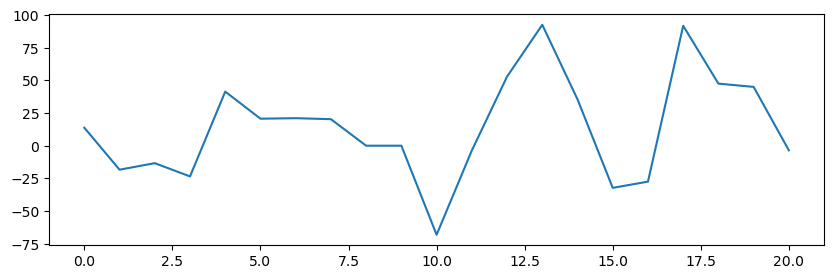

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [8, 9]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 22/29
Found 3 similar days for inquiry 21
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2564.42, original cost 2573.78, (reduction 9.36)
Discovered valid strategy strategy_2, cost 2568.14, original cost 2573.78, (reduction 5.64)
Discovered valid strategy strategy_5, cost 2564.99, original cost 2573.78, (reduction 8.79)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_1, cost 2568.96, original cost 2573.78, (reduction 4.81)
Discovered valid strategy strategy_6, cost 2570.63, original cost 2573.78, (reduction 3.15)
Discovered valid strategy strategy_8, cost 2559.64, origi

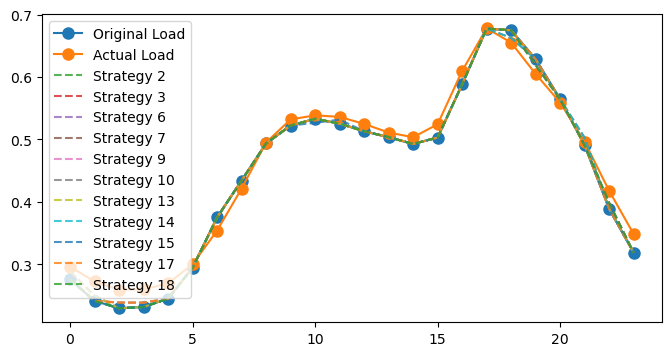

Found 1 relevant failed reflection cases for inquiry 21


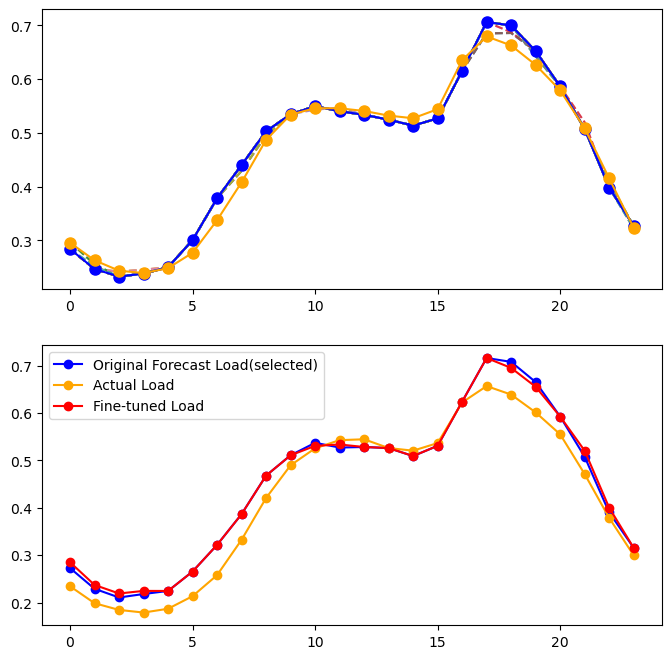

Original cost: 2559.960087402344, Fine-tuned cost: 2562.6758236845108
Strategy generation attempt #1 (Current valid strategies: 0/5)
Discovered valid strategy strategy_1, cost 2546.69, original cost 2559.96, (reduction 13.27)
Discovered valid strategy strategy_3, cost 2549.17, original cost 2559.96, (reduction 10.79)
Strategy generation attempt #2 (Current valid strategies: 2/5)
Providing actual load values
Discovered valid strategy strategy_5, cost 2549.82, original cost 2559.96, (reduction 10.14)
Strategy generation attempt #3 (Current valid strategies: 3/5)
Providing actual load values
Discovered valid strategy strategy_2, cost 2548.66, original cost 2559.96, (reduction 11.30)
Discovered valid strategy strategy_3, cost 2549.82, original cost 2559.96, (reduction 10.14)
2885.3958172274506
2872.2444398466378


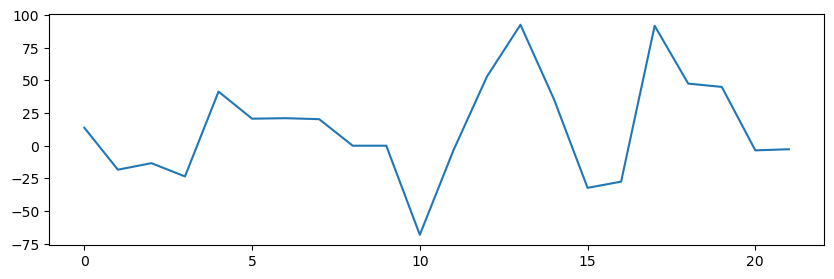

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [8, 9]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 23/29
Found 3 similar days for inquiry 22
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2644.05, original cost 2660.95, (reduction 16.90)
Discovered valid strategy strategy_5, cost 2657.95, original cost 2660.95, (reduction 3.00)
Discovered valid strategy strategy_8, cost 2654.05, original cost 2660.95, (reduction 6.90)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_1, cost 2644.05, original cost 2660.95, (reduction 16.90)
Discovered valid strategy strategy_3, cost 2648.03, original cost 2660.95, (reduction 12.92)
Discovered valid strategy strategy_5, cost 2657.95, or

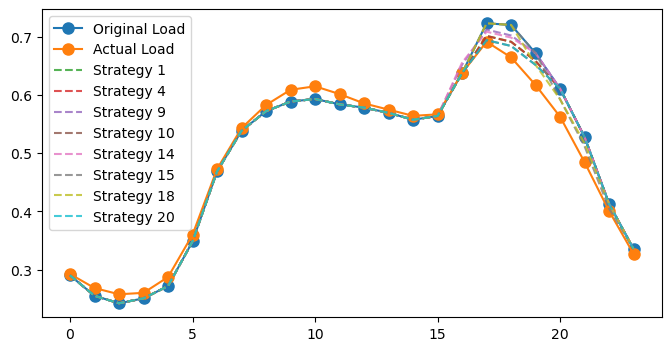

Found 1 relevant failed reflection cases for inquiry 22


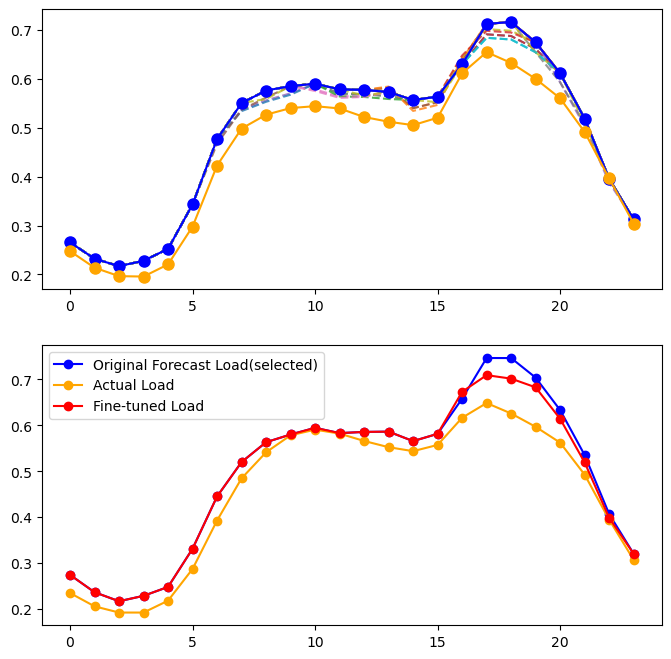

Original cost: 2667.900646484375, Fine-tuned cost: 2633.030131326246
2875.9395054560123
2861.843817737056


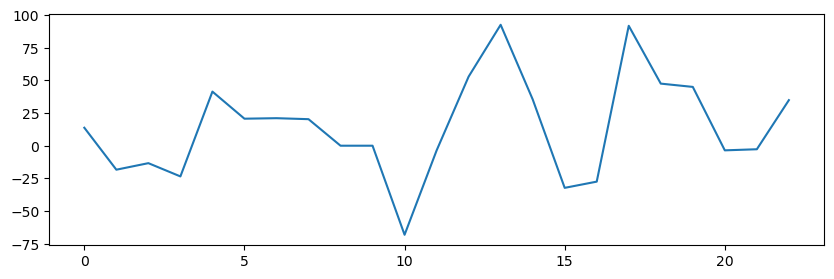

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [8, 9]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 24/29
Found 3 similar days for inquiry 23
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2650.63, original cost 2669.37, (reduction 18.74)
Discovered valid strategy strategy_3, cost 2664.68, original cost 2669.37, (reduction 4.69)
Discovered valid strategy strategy_7, cost 2667.06, original cost 2669.37, (reduction 2.31)
Discovered valid strategy strategy_8, cost 2667.12, original cost 2669.37, (reduction 2.25)
Strategy generation attempt #2 (Current valid strategies: 4/20)
Discovered valid strategy strategy_1, cost 2653.44, original cost 2669.37, (reduction 15.93)
Discovered valid strategy strategy_3, cost 2664.69, ori

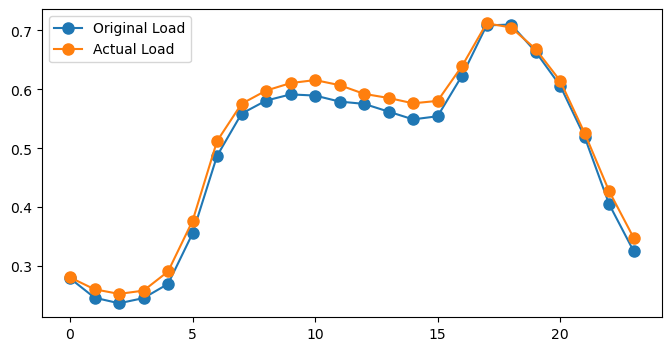

Inquiry 23: No valid strategy found, using original curve as fine-tuned result.
2874.705233520508
2861.1968661231745


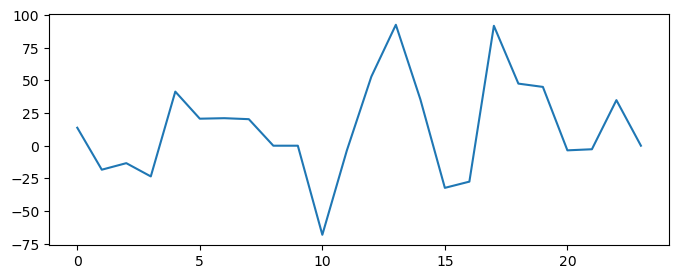

Processing inquiry 25/29
Found 3 similar days for inquiry 24
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
执行策略代码块失败: invalid syntax (<string>, line 1)
No valid strategy functions generated
Strategy generation attempt #2 (Current valid strategies: 0/20)
Discovered valid strategy strategy_3, cost 2574.76, original cost 2577.78, (reduction 3.02)
Discovered valid strategy strategy_5, cost 2569.05, original cost 2577.78, (reduction 8.73)
Discovered valid strategy strategy_8, cost 2564.64, original cost 2577.78, (reduction 13.14)
Strategy generation attempt #3 (Current valid strategies: 3/20)
Providing actual load values
Discovered valid strategy strategy_5, cost 2572.26, original cost 2577.78, (reduction 5.52)
Strategy generation attempt #4 (Current valid strategies: 4/20)
Providing actual load values
Discovered valid strategy strategy_2, cost 2564.76, original cost 2577.78, (reduction 13.02)
Discovered valid strategy s

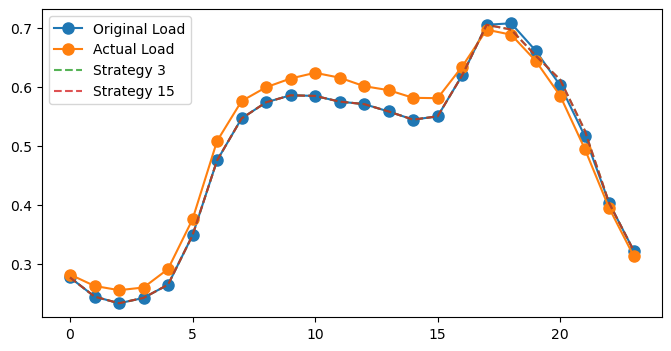

Found 1 relevant failed reflection cases for inquiry 24


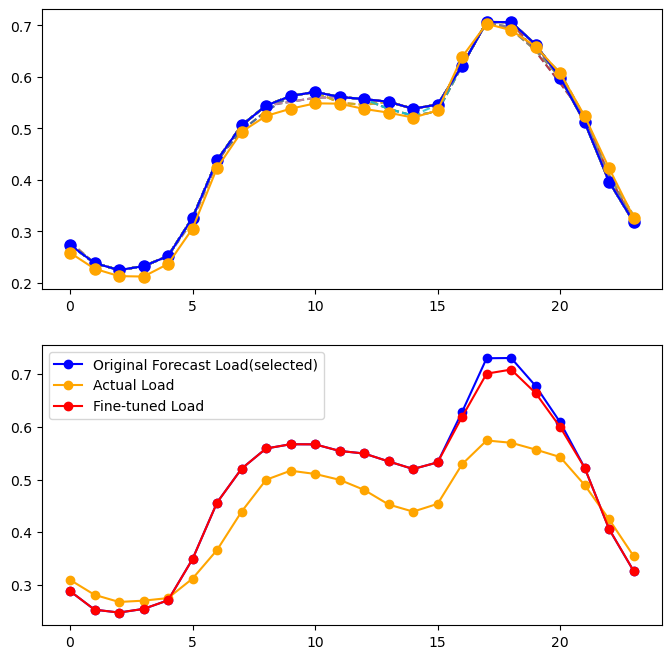

Original cost: 2825.067557128906, Fine-tuned cost: 2802.9209084594577
2872.719726464844
2858.865827816626


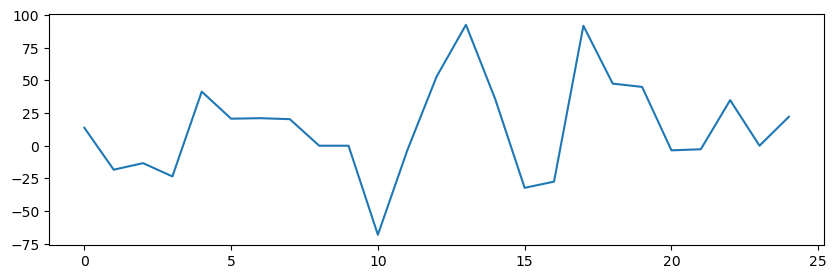

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [8, 9, 23]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 26/29
Found 3 similar days for inquiry 25
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2606.61, original cost 2621.43, (reduction 14.82)
Discovered valid strategy strategy_2, cost 2607.17, original cost 2621.43, (reduction 14.26)
Discovered valid strategy strategy_6, cost 2605.26, original cost 2621.43, (reduction 16.16)
Discovered valid strategy strategy_8, cost 2611.25, original cost 2621.43, (reduction 10.18)
Discovered valid strategy strategy_9, cost 2607.18, original cost 2621.43, (reduction 14.25)
Strategy generation attempt #2 (Current valid strategies: 5/20)
Discovered valid strategy strategy_1, cost 2606.

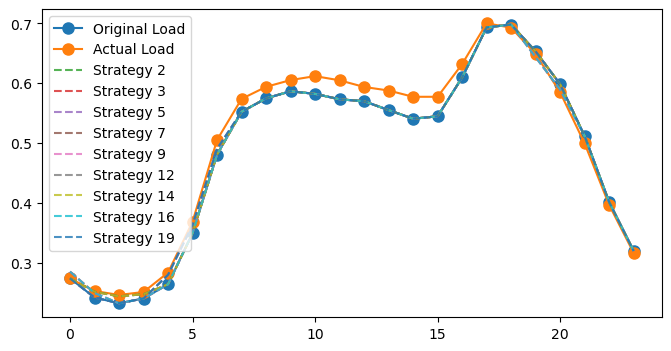

Found 1 relevant failed reflection cases for inquiry 25


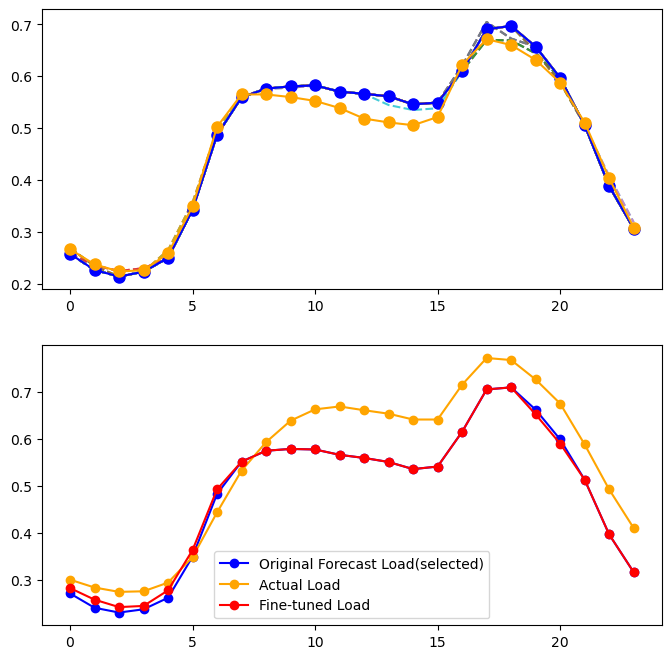

Original cost: 3709.3938129882818, Fine-tuned cost: 3683.9141125242295
2904.899499023438
2890.5984541515336


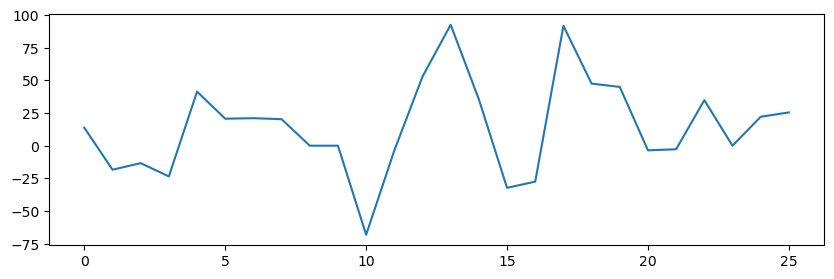

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [8, 9, 23]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 27/29
Found 3 similar days for inquiry 26
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2798.56, original cost 2816.96, (reduction 18.40)
Discovered valid strategy strategy_2, cost 2793.50, original cost 2816.96, (reduction 23.45)
Discovered valid strategy strategy_3, cost 2813.48, original cost 2816.96, (reduction 3.48)
Discovered valid strategy strategy_5, cost 2804.34, original cost 2816.96, (reduction 12.61)
Discovered valid strategy strategy_6, cost 2807.88, original cost 2816.96, (reduction 9.07)
Discovered valid strategy strategy_7, cost 2808.88, original cost 2816.96, (reduction 8.07)
Discovered valid strat

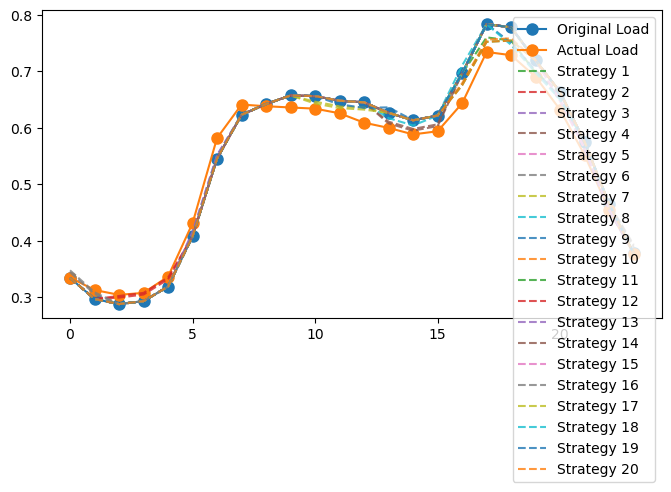

Found 1 relevant failed reflection cases for inquiry 26


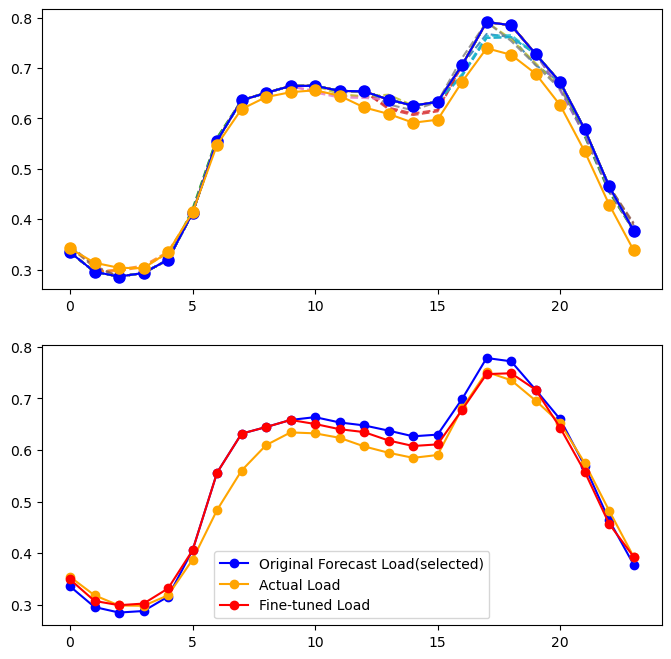

Original cost: 2837.7788227539068, Fine-tuned cost: 2773.4168513849377
2902.4135480504924
2886.2583947898083


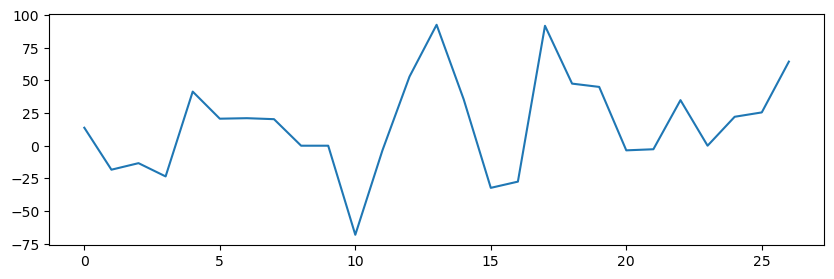

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [8, 9, 23]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 28/29
Found 3 similar days for inquiry 27
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2543.30, original cost 2559.97, (reduction 16.67)
Discovered valid strategy strategy_8, cost 2553.66, original cost 2559.97, (reduction 6.31)
Strategy generation attempt #2 (Current valid strategies: 2/20)
Discovered valid strategy strategy_1, cost 2543.30, original cost 2559.97, (reduction 16.67)
Discovered valid strategy strategy_4, cost 2554.03, original cost 2559.97, (reduction 5.93)
Discovered valid strategy strategy_6, cost 2554.12, original cost 2559.97, (reduction 5.85)
Discovered valid strategy strategy_8, cost 2553.66,

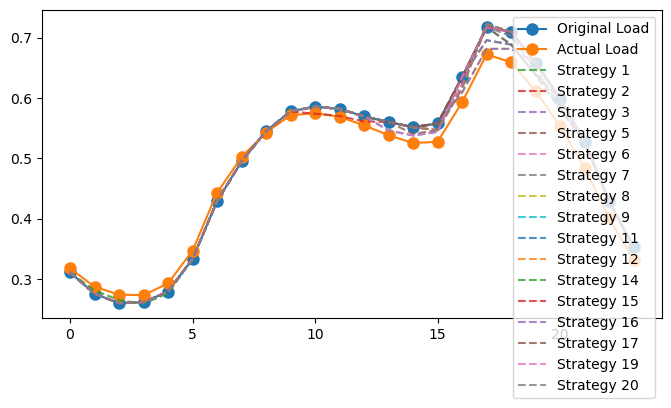

Found 1 relevant failed reflection cases for inquiry 27


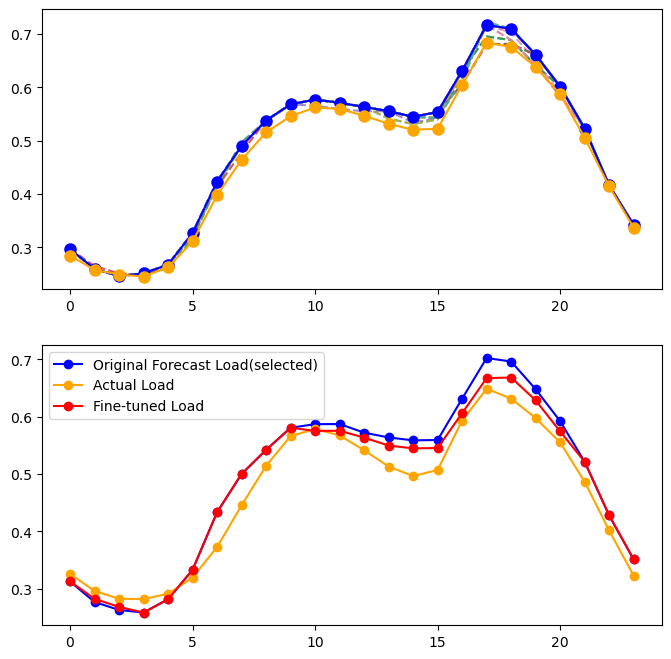

Original cost: 2692.061259765625, Fine-tuned cost: 2634.381016958988
2894.900966326033
2877.262774152993


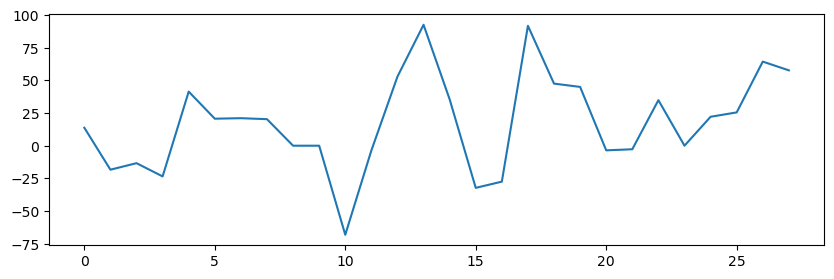

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [8, 9, 23]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 29/29
Found 3 similar days for inquiry 28
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2557.35, original cost 2573.78, (reduction 16.43)
Discovered valid strategy strategy_2, cost 2571.36, original cost 2573.78, (reduction 2.42)
Discovered valid strategy strategy_6, cost 2562.98, original cost 2573.78, (reduction 10.80)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_1, cost 2557.35, original cost 2573.78, (reduction 16.43)
Discovered valid strategy strategy_2, cost 2571.36, original cost 2573.78, (reduction 2.42)
Discovered valid strategy strategy_6, cost 2562.98

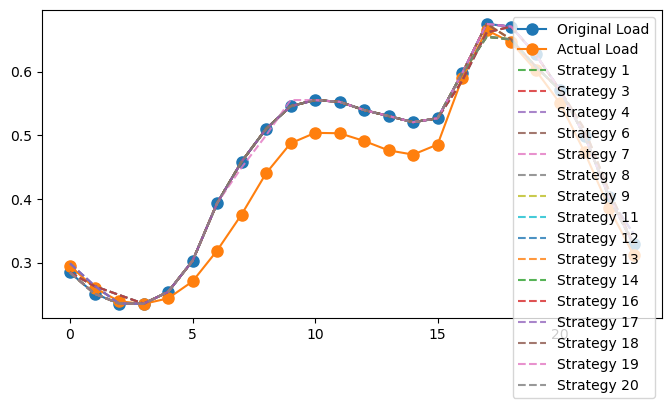

Found 1 relevant failed reflection cases for inquiry 28


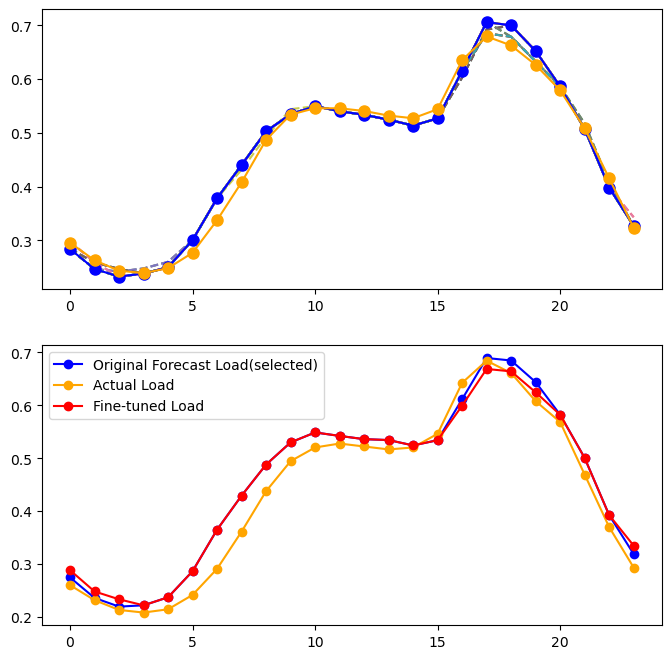

Original cost: 2546.3272666015623, Fine-tuned cost: 2568.550434818393
Strategy generation attempt #1 (Current valid strategies: 0/5)
Discovered valid strategy strategy_8, cost 2542.71, original cost 2546.33, (reduction 3.62)
Discovered valid strategy strategy_9, cost 2544.44, original cost 2546.33, (reduction 1.88)
Strategy generation attempt #2 (Current valid strategies: 2/5)
Providing actual load values
Discovered valid strategy strategy_4, cost 2540.89, original cost 2546.33, (reduction 5.43)
Discovered valid strategy strategy_6, cost 2544.44, original cost 2546.33, (reduction 1.88)
Discovered valid strategy strategy_7, cost 2543.44, original cost 2546.33, (reduction 2.89)
2882.881183576914
2866.6175210724896


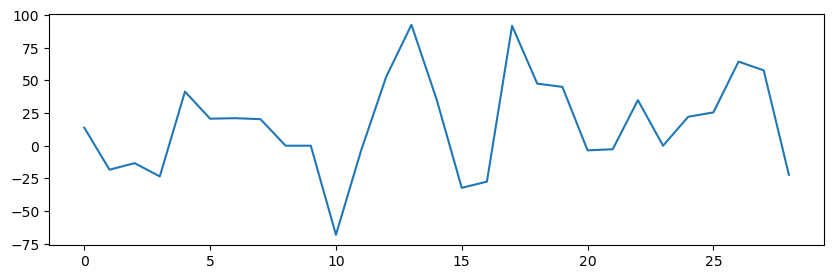

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [8, 9, 23]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []


In [ ]:
fine_tuned_result_given_by_LLM = {
    'selected_flag': [], 'original_load': [], 'optnet_load': [], 'fine_tuned_load': [], 
    'cost_org': [], 'cost_optnet': [], 'cost_after': [], 'actual_load': [],
    'few_shot_curves': [], 'few_shot_costs': [], 'few_shot_code': [], 
    'similar_load': [], 'similar_actual_load': [], 'strategy_code': []
}

skip_samples = []
validate_failures = []
reflection_records = []

for inqure_id in range(len(forecasts_load_test_insert)):
    print(f"Processing inquiry {inqure_id+1}/{len(forecasts_load_test_insert)}")
    data_for_inqure = {
        'load': forecasts_load_test_insert[inqure_id],
    }

    similar_days = db_train.get_top_k_unique_loads(data_for_inqure['load'], k=3, q=1)[0:3]
    average_similar_load_org = np.mean([day['load'] for day in similar_days], axis=0)
    average_similar_load_actual = np.mean([day['actual_load'] for day in similar_days], axis=0)
    average_similar_load_org_numpy = train_load_data.scaler_y.inverse_transform(np.array(average_similar_load_org).reshape(1,-1))[0]
    average_similar_load_actual_numpy = train_load_data.scaler_y.inverse_transform(np.array(average_similar_load_actual).reshape(1,-1))[0]
    _, _, obj_org_similar_days = optimization_module.forward(average_similar_load_org_numpy, average_similar_load_actual_numpy)
    obj_org_similar_days = obj_org_similar_days.item()

    selected_flag = 'org'
    load_nor = data_for_inqure['load']
    average_similar_load = average_similar_load_org
    actual_load_numpy = train_load_data.scaler_y.inverse_transform(np.array(actual_load_test_insert[inqure_id]).reshape(1,-1))[0]
    load_numpy_org = train_load_data.scaler_y.inverse_transform(np.array(data_for_inqure['load']).reshape(1,-1))[0]
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    higher_flag = "higher" if sum(np.array(average_similar_load) - np.array(average_similar_load_actual)) > 0 else "lower"
    reduce_flag = "reduce" if higher_flag == "higher" else "increase"
    print(f"Found {len(similar_days)} similar days for inquiry {inqure_id}")
    
    system_prompt = generate_prompt_sys(args, data_for_inqure)

    full_user_prompt = f"SYSTEM INSTRUCTIONS:\n{system_prompt}."
    full_user_prompt += f"""\n\nHint: You have two approaches to reduce cost:  

    1. Compare the actual value and forecast of the similar day, try to learn some error reduction strategies. In historical similar days, we found the forecasts were {higher_flag} than actual, so you can try to {reduce_flag} the load in some hours to reduce cost.  
    2. Compare the future positive and negative reserve prices.  
    - If the positive reserve price is much higher than the negative reserve price, you should schedule more generation in the day-ahead market.  
    - If the negative reserve price is higher, schedule less generation to reduce potential costs.  
    """

    # Few-shot code integration
    print("Generating few-shot prompts based on similar days...")
    strategy_history, valid_strategies = few_shot_prompt_generate(args, similar_days, max_strategies=20, max_attempts=6)
    
    # Validate strategies on validation set
    selected_strategy = []
    similar_days_val = db_val.get_top_k_unique_loads(data_for_inqure['load'], k=3, q=1)[0:3]
    average_similar_load_val = np.mean([day['load'] for day in similar_days_val], axis=0)
    average_similar_load_actual_val = np.mean([day['actual_load'] for day in similar_days_val], axis=0)
    plt.figure(figsize=(8, 4))
    plt.plot(range(len(average_similar_load_val)), average_similar_load_val, markersize=8, marker='o', label='Original Load')
    plt.plot(range(len(average_similar_load_val)), average_similar_load_actual_val, markersize=8, marker='o', label='Actual Load')
    
    load_nor_val = average_similar_load_val.tolist()
    load_val_numpy = train_load_data.scaler_y.inverse_transform(np.array(load_nor_val).reshape(1,-1))[0]
    actual_load_val_numpy = train_load_data.scaler_y.inverse_transform(np.array(average_similar_load_actual_val).reshape(1,-1))[0]

    for strategy in valid_strategies:
        strategy_result = evaluate_individual_strategies(
            strategy['code'],
            load_nor_val,
            max_change_percent=0.1
        )
        selected_curve_val = strategy_result[list(strategy_result.keys())[0]]['adjusted_curve']

        fine_tune_load_val_numpy = train_load_data.scaler_y.inverse_transform(np.array(selected_curve_val).reshape(1,-1))[0]
        _, _, obj_org_val = optimization_module.forward(load_val_numpy, actual_load_val_numpy)
        _, _, obj_fine_tune_val = optimization_module.forward(fine_tune_load_val_numpy, actual_load_val_numpy)

        if obj_org_val > obj_fine_tune_val:
            selected_strategy.append(strategy)
            plt.plot(range(24), selected_curve_val, label=strategy['name'], linestyle='--', alpha=0.8)
            print(f"Strategy {strategy['name']} succeeded on validation set, cost {obj_fine_tune_val.item():.2f}, original cost {obj_org_val.item():.2f}, (reduction {obj_org_val.item()-obj_fine_tune_val.item():.2f})")
        else:
            print(f"Strategy {strategy['name']} failed on validation set, cost {obj_fine_tune_val.item():.2f}, original cost {obj_org_val.item():.2f}, (increase {obj_org_val.item()-obj_fine_tune_val.item():.2f})")
    plt.legend()
    plt.show()

    # Skip if no valid fine-tuning strategies found
    if len(selected_strategy) == 0:
        print(f"Inquiry {inqure_id}: No valid strategy found, using original curve as fine-tuned result.")
        _, _, obj_org = optimization_module.forward(load_numpy_org, actual_load_numpy)

        fine_tuned_result_given_by_LLM['fine_tuned_load'].append(data_for_inqure['load'])
        fine_tuned_result_given_by_LLM['cost_after'].append(obj_org.item())

        fine_tuned_result_given_by_LLM['selected_flag'].append(selected_flag)
        fine_tuned_result_given_by_LLM['actual_load'].append(actual_load_test_insert[inqure_id])
        fine_tuned_result_given_by_LLM['original_load'].append(data_for_inqure['load'])
        fine_tuned_result_given_by_LLM['similar_load'].append(average_similar_load.tolist())
        fine_tuned_result_given_by_LLM['similar_actual_load'].append(average_similar_load_actual.tolist())
        fine_tuned_result_given_by_LLM['cost_org'].append(obj_org.item())
        fine_tuned_result_given_by_LLM['few_shot_costs'].append([])
        fine_tuned_result_given_by_LLM['few_shot_curves'].append([])
        fine_tuned_result_given_by_LLM['few_shot_code'].append([])
        fine_tuned_result_given_by_LLM['strategy_code'].append('')
        skip_samples.append(inqure_id)
        # Visualization
        if len(fine_tuned_result_given_by_LLM['cost_org']) > 1:
            print(np.mean(fine_tuned_result_given_by_LLM['cost_org']))
            print(np.mean(fine_tuned_result_given_by_LLM['cost_after']))
            plt.figure(figsize=(8, 3))
            plt.plot(
                range(len(fine_tuned_result_given_by_LLM['cost_org'])),
                np.array(fine_tuned_result_given_by_LLM['cost_org']) - np.array(fine_tuned_result_given_by_LLM['cost_after']),
                label='Compared to original'
            )
            plt.show()
            plt.close()
        continue

    # Build few-shot LLM prompt
    few_shot_costs = [s['final_cost'] for s in selected_strategy]
    few_shot_curves = [s['adjusted_curve'] for s in selected_strategy]
    few_shot_codes = [s['code'] for s in selected_strategy]
    history_snippet_prompt = 'Here are some previously discovered effective adjustment strategies:\n'
    for i, s in enumerate(selected_strategy):
        history_snippet_prompt += f"Good strategy {i+1} from few-shot:\n{s['code']}\n\n"
    history_snippet_prompt += f"You should ensemble these strategies as you can only output one adjustment_strategy function.\n"

    last_fail_reflections = get_fail_reflections_by_curve_distance(reflection_records, data_for_inqure['load'], max_num=1)
    print(f"Found {len(last_fail_reflections)} relevant failed reflection cases for inquiry {inqure_id}")
    fail_reflections_prompt = ""
    if last_fail_reflections:
        fail_reflections_prompt = 'You have failed in these examples and led to cost increase, avoid these patterns:\n'
        fail_reflections_prompt += "\n### Previous failed adjustment text examples (avoid these patterns):\n"
        for idx, record in enumerate(last_fail_reflections):
            fail_reflections_prompt += (
                f"Fail Case {idx + 1}:\n"
                f"- Last failed strategy:\n{remove_comments(record['strategy_code'])}\n\n"
                f"- Successful strategy:\n{(record['reflection_strategy'])}\n\n"
            )

    if args.LLM_type == 'Qwen':
        response = Generation.call(
            model="qwen-plus",
            messages=[
                {"role": "system", "content": full_user_prompt},
                {"role": "user", "content": output_require_prompt},
                {"role": "assistant", "content": history_snippet_prompt},
                {"role": "assistant", "content": fail_reflections_prompt},
            ],
            parameters={
                "temperature": 0.1,
                "result_format": "text",
                "max_tokens": 2048,
                "top_k": 10
            }
        )
        raw_text = response.output.text.strip()
        func_code = extract_pure_code(raw_text)


    elif args.LLM_type == 'Deepseek':
        client = OpenAI(api_key=DEEPSEEK_API_KEY,
                base_url="https://api.deepseek.com")
        response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
            {"role": "system", "content": full_user_prompt},
            {"role": "user", "content": output_require_prompt},
            {"role": "assistant", "content": history_snippet_prompt},
            {"role": "assistant", "content": fail_reflections_prompt},
        ],
        temperature=0.1,
        max_tokens=2048,
        stream=False,
        )
        raw_text = response.choices[0].message.content.strip()
        func_code = extract_pure_code(raw_text)
        
    elif args.LLM_type=='Llama':
        client = Together(api_key=LLAMA_API_KEY)
        response = client.chat.completions.create(
            model="meta-llama/Llama-4-Scout-17B-16E-Instruct",  # 可替换为其他 Llama 版本
            messages=[
            {"role": "system", "content": full_user_prompt},
            {"role": "user", "content": output_require_prompt},
            {"role": "assistant", "content": history_snippet_prompt},
            {"role": "assistant", "content": fail_reflections_prompt},
        ],
        temperature=0.1,
        max_tokens=2048,
        )
        raw_text = response.choices[0].message.content.strip()
        func_code = extract_pure_code(raw_text)
    
    if selected_flag == 'org':
        selected_curve, delta_curve, strategy_code = execute_strategy_function(
            func_code,
            data_for_inqure['load'],
            max_change_percent=0.1
        )
    else:
        selected_curve, delta_curve, strategy_code = execute_strategy_function(
            func_code,
            data_for_inqure['fine_tuned_load'],
            max_change_percent=0.1
        )

    fine_tune_load_numpy =  train_load_data.scaler_y.inverse_transform(np.array(selected_curve).reshape(1, -1))[0]
    _, _, obj_org = optimization_module.forward(load_numpy_org, actual_load_numpy)
    _, _, obj_fine_tune = optimization_module.forward(fine_tune_load_numpy, actual_load_numpy)

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    for i in valid_strategies:
        plt.plot(i['adjusted_curve'], label=i['name'], linestyle='--', alpha=0.8)
    if selected_flag == 'org':
        plt.plot(range(24), i['original_load'], markersize=8, marker='o', label='Original Load', color='blue')
    else:
        plt.plot(range(24), i['original_load'], markersize=8, marker='o', label='Optnet Load', color='green')
    plt.plot(range(24), i['actual_load'], markersize=8, marker='o', label='Actual Load', color='orange')
    # plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(range(24), data_for_inqure['load'], label='Original Forecast Load(selected)', marker='o', color='blue')
    plt.plot(range(24), actual_load_test_insert[inqure_id], label='Actual Load', marker='o', color='orange')
    plt.plot(range(24), selected_curve, label='Fine-tuned Load', marker='o', color='red')
    plt.legend()
    plt.show()
    print(f"Original cost: {obj_org.item()}, Fine-tuned cost: {obj_fine_tune.item()}")

    if selected_flag == 'org' and obj_fine_tune.item() < obj_org.item():
            reflection_strategy = "Cost reduction achieved."
            insight = f"Successfully reduced cost by {obj_org.item() - obj_fine_tune.item():.2f}."
    elif selected_flag == 'org' and obj_fine_tune.item() > obj_org.item():
        failures = [{
            "inqure_id": inqure_id,
            "load": data_for_inqure['load'],
            "actual_load": actual_load_test_insert[inqure_id],
            'fine_tuned_load': selected_curve,
            "cost_before": obj_org.item(),
            "cost_after": obj_fine_tune.item(),
            "strategy_code": strategy_code,
        }]

        reflection_strategy_history, reflection_valid_strategies = few_shot_prompt_generate(args, failures, max_strategies=5, max_attempts=3,failure_strategy=strategy_code)
        reflection_strategy = f"For this failure case, consider:"
        for i in range(len(reflection_valid_strategies)):
            strategy = reflection_valid_strategies[i]
            reflection_strategy += f"Successful strategy {i} for failure case:\n{remove_comments(strategy['code'])}\n"

    reflection_records.append({
        "inquiry_id": inqure_id,
        "original_load": data_for_inqure['load'],
        "actual_load": actual_load_test_insert[inqure_id],
        "fine_tuned_load": selected_curve,
        "cost_before": obj_org.item(),
        "cost_after": obj_fine_tune.item(),
        "strategy_code": strategy_code,
        "reflection_strategy": reflection_strategy,
        "similar_day_comparison": f"Similar days showed forecast was {higher_flag} than actual"
    })
    reflection_records = reflection_records[-10:]  # Keep only last 10 records

    fine_tuned_result_given_by_LLM['selected_flag'].append(selected_flag)
    fine_tuned_result_given_by_LLM['actual_load'].append(actual_load_test_insert[inqure_id])
    fine_tuned_result_given_by_LLM['original_load'].append(data_for_inqure['load'])
    fine_tuned_result_given_by_LLM['fine_tuned_load'].append(selected_curve)
    fine_tuned_result_given_by_LLM['cost_after'].append(obj_fine_tune.item())
    fine_tuned_result_given_by_LLM['cost_org'].append(obj_org.item())
    fine_tuned_result_given_by_LLM['similar_load'].append(average_similar_load.tolist())
    fine_tuned_result_given_by_LLM['similar_actual_load'].append(average_similar_load_actual.tolist())
    fine_tuned_result_given_by_LLM['few_shot_costs'].append(few_shot_costs)
    fine_tuned_result_given_by_LLM['few_shot_curves'].append(few_shot_curves)
    fine_tuned_result_given_by_LLM['few_shot_code'].append(few_shot_codes)
    fine_tuned_result_given_by_LLM['strategy_code'].append(strategy_code)

    if len(fine_tuned_result_given_by_LLM['cost_org']) > 1:
        print(np.mean(fine_tuned_result_given_by_LLM['cost_org']))
        print(np.mean(fine_tuned_result_given_by_LLM['cost_after']))
        plt.figure(figsize=(10, 3))
        plt.plot(
            range(len(fine_tuned_result_given_by_LLM['cost_org'])),
            np.array(fine_tuned_result_given_by_LLM['cost_org']) - np.array(fine_tuned_result_given_by_LLM['cost_after']),
            label='Compared to original'
        )
        plt.show()
        plt.close()

    print(f"The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: {skip_samples}")
    print(f"The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: {validate_failures}")

    with open('../Result/NN+MILP/'+args.LLM_type+'.pkl', 'wb') as f:
        pickle.dump(fine_tuned_result_given_by_LLM, f)

### result

In [37]:
print(np.mean(cost_list_ideal))
print(np.mean(fine_tuned_result_given_by_LLM['cost_org']))
print(np.mean(fine_tuned_result_given_by_LLM['cost_after']))

2526.3265333333334
2882.881183576914
2866.6175210724896
